In [2]:
%matplotlib inline

In [3]:
#!pip install -r requirements.txt

In [4]:
import pandas as pd
import numpy as np
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool, cv as catboost_cv
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV,
                                     KFold, LeaveOneOut, LeavePOut)
# --- Import scikit-learn metrics directly ---
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer

from scipy.stats import randint, uniform
import optuna # Added import
from imblearn.over_sampling import RandomOverSampler # Added import

# Import necessary functions from utils.py (excluding metrics)
from utils import (
    plot_pred_vs_actual_plotly,
    plot_shap_summary,
    plot_shap_waterfall,
    plot_shap_dependence,
    plot_native_feature_importance # Keep native importance plot
    # Removed RMSE, MAPE, calculate_r2 from utils import
)

from meteostat import Point, Daily
import joblib

In [5]:
DATA_PATH = "data/conso_data.csv"
TARGET_COLUMN = "pitd"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Tuning settings
N_ITER_RANDOM_SEARCH = 65 # Iterations for RandomizedSearchCV
N_TRIALS_OPTUNA = 100      # Trials for Optuna optimization
CV_FOLDS_TUNING = 5       # Folds for CV during tuning

# File to save/load best parameters
PARAMS_FILENAME = 'best_catboost_params.json'

# Oversampling settings
HOLIDAY_COLUMN = 'is_holiday' # *** IMPORTANT: ASSUMING this column exists or will be created ***
ENABLE_OVERSAMPLING = False

GRID_SEARCH_POINTS = 3 # Number of points per continuous parameter in Grid Search (e.g., 3 = low, center, high)
GRID_SEARCH_RANGE_FACTOR = 0.15 

In [6]:
df = pd.read_csv("data/conso_data.csv")
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'] - pd.Timedelta(hours=6)
df.drop(columns = ['pitd1','pitd2','pitd7','target', 'target1', 'target2', 'pitd_terega', 'target7'], inplace = True)

In [7]:
# Calculate Heating Degree Days (HDD)
base_temp = 16.5
# Ensure 'tmoy' is numeric before calculation
df['tmoy'] = pd.to_numeric(df['tmoy'], errors='coerce')
df['hdd'] = (base_temp - df['tmoy']).clip(lower=0)
df['rolling_hdd_7'] = df['hdd'].rolling(7, min_periods=1).sum()

In [8]:
for l in [1, 2, 3, 7, 14]:
    df[f'pitd_lag{l}'] = df['pitd'].shift(l)
    df[f'hdd_lag{l}']  = df['hdd'].shift(l)
    df[f'tmoy_lag{l}'] = df['tmoy'].shift(l)

df['lag1_to_lag7_ratio']= df['pitd_lag1'] / df['pitd_lag7']
# --- Rolling statistics ------------------------------------------
for w in [3, 7, 14]:
    df[f'pitd_ma_{w}']  = df['pitd'].shift(1).rolling(w, min_periods=1).mean()
    df[f'pitd_ewm_{w}'] = df['pitd'].shift(1).ewm(span=w, adjust=False).mean()
    df[f'pitd_std_{w}'] = df['pitd'].shift(1).rolling(w, min_periods=1).std()

# --- Weekend × season interaction --------------------------------
df['is_winter'] = (df['season_metero'].str.lower() == 'winter').astype(int)
df['weekend_winter'] = df['weekend'] * df['is_winter']
df['weekend_cold'] = df['weekend'] * df['hdd']

# --- Cyclical (sin/cos) terms — kept for clarity ------------------
df['day_of_year'] = pd.to_datetime(df['date']).dt.dayofyear
df['sin_doy'] = np.sin(2 * np.pi * df['day_of_year']/365.25)
df['cos_doy'] = np.cos(2 * np.pi * df['day_of_year']/365.25)

df.bfill(inplace=True)

In [9]:
# %%
# ------------------------------------------------------------------
# FEATURE BLOCK ② — external Meteorological features via Meteostat
#   (always reset_index on load as well as on fetch)
# ------------------------------------------------------------------
from meteostat import Point, Daily
import pandas as pd, os, joblib

CACHE_FILE = "data/_wx_cache.joblib"

def fetch_station_series(lat=48.8566, lon=2.3522):
    """Download (or load cached) wind & diurnal temp range for Paris dates."""
    if os.path.exists(CACHE_FILE):
        daily = joblib.load(CACHE_FILE)
        # — even on load, make sure the index is tz-naive and turned into a column:
        daily.index = daily.index.tz_localize(None)
        daily.index.name = 'date'
        return daily.reset_index()

    # tz-naive start/end
    start = pd.to_datetime(df['date']).min().to_pydatetime().replace(tzinfo=None)
    end   = pd.to_datetime(df['date']).max().to_pydatetime().replace(tzinfo=None)

    point = Point(lat, lon)
    daily = Daily(point, start=start, end=end).fetch()

    # keep only wind & tmin/tmax → derive t_range
    keep = [c for c in ['wspd','tmin','tmax'] if c in daily.columns]
    daily = daily[keep].rename(columns={'wspd':'windspeed'})

    if 'tmin' in daily.columns and 'tmax' in daily.columns:
        daily['t_range'] = daily['tmax'] - daily['tmin']
        daily = daily.drop(columns=['tmin','tmax'])

    daily.index = daily.index.tz_localize(None)
    daily.index.name = 'date'

    joblib.dump(daily, CACHE_FILE)
    return daily.reset_index()

# re-fetch & merge
wx = fetch_station_series()

# normalize both sides
df['date'] = pd.to_datetime(df['date']).dt.normalize().dt.tz_localize(None)

# make sure wx.date is midnight (it already should be, but safe)
wx['date'] = pd.to_datetime(wx['date']).dt.normalize().dt.tz_localize(None)

df = (
    df
    .merge(wx, on='date', how='left')
    .assign(hdd_wind=lambda x: x['hdd'] * (1 + x['windspeed']/10))
)




In [10]:

df['date'] = pd.to_datetime(df['date']) + pd.Timedelta(hours=6)

df = df.dropna(subset=['pitd_lag1','windspeed','t_range']).reset_index(drop=True)

In [11]:
df['perceived_temp'] = 0.7*df['tmoy'] + 0.3*df['teff_cwv']
# --- Heating-Load Regime (binary, “on/off”) -----------------------
df['heating_on'] = (df['perceived_temp'] < 16.5).astype(int)  # perceived_temp defined below


# --- Calendar proximity to holidays (in days) --------------------
holidays = df.loc[df['isHoliday']==True, 'date']
nearest_hday = pd.to_datetime(df['date']).apply(
    lambda d: (abs(holidays - d)).min().days if not holidays.empty else np.nan
)
df['days_to_holiday'] = nearest_hday

# --- Cross feature: HDD × business-day ---------------------------
df['hdd_bizday'] = df['hdd'] * df['isBizday']

# --- Ensure no missing values sneaked in -------------------------
df.bfill(inplace=True)


In [12]:
# Convert object to category
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

In [13]:
X = df.drop(columns=["pitd"]) #target
y = df['pitd']

In [14]:
num_variables = X.columns[X.dtypes == 'float64'].tolist()
cat_variables = X.columns[X.dtypes == 'category'].tolist()

In [15]:
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
datetime_cols = X_train_sel.select_dtypes(include=['datetime64[ns]']).columns.tolist()
print("Dropping datetime cols for FS:", datetime_cols)

Xfs_train = X_train_sel.drop(columns=datetime_cols)
Xfs_test  = X_test_sel.drop(columns=datetime_cols)

cat_feats_fs = Xfs_train.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_feats_fs:
    Xfs_train[c] = Xfs_train[c].astype('category')
    Xfs_test [c] = Xfs_test [c].astype('category')
print("Categorical features for FS:", cat_feats_fs)
selected_rfecv = ['li', 'li_terega', 'temp_mean', 'tmoy', 'teff_optim', 'teff_constr', 'teff_cwv', 'tmoy_diff_1', 'teff_constr_diff_1', 'teff_cwv_diff_1', 'year', 'isBizday', 'cosinus', 'wday', 'daydur', 'hdd', 'rolling_hdd_7', 'pitd_lag1', 'hdd_lag1', 'tmoy_lag1', 'pitd_lag2', 'hdd_lag3', 'pitd_lag7', 'hdd_lag7', 'pitd_lag14', 'pitd_ma_3', 'pitd_ewm_3', 'pitd_ma_7', 'pitd_ewm_7', 'pitd_ewm_14', 'day_of_year', 'cos_doy', 't_range', 'hdd_wind', 'perceived_temp', 'hdd_bizday']
X_rfecv    = Xfs_train[selected_rfecv]
cats_rfecv = [c for c in cat_feats_fs if c in selected_rfecv]
X_rfecv_test = Xfs_test[selected_rfecv]


Dropping datetime cols for FS: ['date']
Categorical features for FS: ['below16.5_abc', 'type_vol', 'month', 'weekdays', 'season', 'season_astrono', 'season_metero', 'public_holidays', 'extended_holidays', 'dow', 'ponts_publics_abc', 'ponts_extended_abc']


In [16]:
#
## %%
#import numpy as np
#from sklearn.feature_selection import RFECV
#from sklearn.metrics import make_scorer, root_mean_squared_error
#from catboost import CatBoostRegressor
#
#
#
## 1) Baseline CatBoost & importances (unchanged) …
#baseline_cb = CatBoostRegressor(
#    iterations=500, learning_rate=0.05, depth=6,
#    random_seed=RANDOM_STATE,
#    cat_features=cat_feats_fs, verbose=False
#)
#baseline_cb.fit(Xfs_train, y_train)
#feat_imp = pd.Series(
#    baseline_cb.get_feature_importance(), index=Xfs_train.columns
#).sort_values(ascending=False)
#
## 2) SFM (unchanged) …
#from sklearn.feature_selection import SelectFromModel
#selector_sfm = SelectFromModel(baseline_cb, threshold='median', prefit=True)
#selected_sfm = Xfs_train.columns[selector_sfm.get_support()].tolist()
#
## 3) RFECV — label-encode cats before feeding to sklearn
#X_enc = Xfs_train.copy()
#for c in cat_feats_fs:
#    X_enc[c] = X_enc[c].cat.codes
#
#rfecv = RFECV(
#    estimator=CatBoostRegressor(
#        iterations=200, learning_rate=0.1, depth=4,
#        random_seed=RANDOM_STATE,
#        cat_features=None,  # cats now numeric codes
#        verbose=False
#    ),
#    step=1,
#    cv=3,
#    scoring=make_scorer(lambda yt, yp: -root_mean_squared_error(yt, yp)),
#    n_jobs=-1
#)
#rfecv.fit(X_enc, y_train)
#
#selected_rfecv = Xfs_train.columns[rfecv.support_].tolist() 
#
#print("SFM kept:", selected_sfm)
#print("RFECV kept:", selected_rfecv)


In [17]:
## %%
#pass
#from sklearn.model_selection import cross_validate, KFold
#import pandas as pd
#
## ─────────────────────────────────────────────────────────────────
## TRAIN & COMPARE: All-features vs SFM-subset vs RFECV-subset (5-fold CV)
## ─────────────────────────────────────────────────────────────────
#
## 1) Prepare the three datasets and their cat_features
#X_all    = Xfs_train
#cats_all = cat_feats_fs
#
#X_sfm    = Xfs_train[selected_sfm]
#cats_sfm = [c for c in cat_feats_fs if c in selected_sfm]
#
#X_rfecv    = Xfs_train[selected_rfecv]
#cats_rfecv = [c for c in cat_feats_fs if c in selected_rfecv]
#
## 2) Define identical CatBoostRegressor configs for fair comparison
#def make_cb(cat_feats):
#    return CatBoostRegressor(
#        iterations=500,
#        learning_rate=0.05,
#        depth=6,
#        random_seed=RANDOM_STATE,
#        cat_features=cat_feats,
#        verbose=False
#    )
#
#models = {
#    'All features':    make_cb(cats_all),
#    'SFM subset':      make_cb(cats_sfm),
#    'RFECV subset':    make_cb(cats_rfecv),
#}
#
## 3) 5-Fold CV settings
#cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
#scoring = {
#    'RMSE': 'neg_root_mean_squared_error',
#    'R2':   'r2'
#}
#
## 4) Run CV
#cv_results = {}
#for name, model in models.items():
#    X_sub = {'All features':X_all,
#             'SFM subset': X_sfm,
#             'RFECV subset': X_rfecv}[name]
#
#    res = cross_validate(
#        model,
#        X_sub,
#        y_train,
#        cv=cv,
#        scoring=scoring,
#        return_train_score=False,
#        n_jobs=-1
#    )
#
#    cv_results[name] = {
#        'RMSE': -res['test_RMSE'].mean(),
#        'R2':    res['test_R2'].mean()
#    }
#
## 5) Summarize
#cv_df = pd.DataFrame(cv_results).T
#cv_df[['RMSE','R2']]


In [18]:
#pass
## %% Compare three CatBoost models via 5-fold CV RMSE
#from catboost import CatBoostRegressor
#from sklearn.model_selection import cross_val_score, KFold
#
## Re-use X_rfecv and y_train from your RFECV cell
#cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
#
## 1) Default CatBoost (no hyperparameters)
#default_cb = CatBoostRegressor(cat_features= cats_rfecv, verbose=False)
#scores_default = cross_val_score(
#    default_cb,
#    X_rfecv, y_train,
#    cv=cv,
#    scoring='neg_root_mean_squared_error',
#    n_jobs=-1
#)
#print(f"Default CatBoost 5-CV RMSE: {-scores_default.mean():.4f}")
#
## 2) Time-aware CatBoost (has_time=True, boosting_type='ordered')
#time_cb = CatBoostRegressor(
#    cat_features=cats_rfecv,
#    has_time=True,
#    boosting_type='Ordered',
#    verbose=False
#)
#scores_time = cross_val_score(
#    time_cb,
#    X_rfecv, y_train,
#    cv=cv,
#    scoring='neg_root_mean_squared_error',
#    n_jobs=-1
#)
#print(f"Time-aware Ordered CatBoost 5-CV RMSE: {-scores_time.mean():.4f}")
#
## 3) “Golden” model: quantize pitd_lag1 & rolling_hdd_7 at 1024 borders + monotone constraints
##    on hdd, hdd_wind, rolling_hdd_7, pitd_lag1, pitd_lag7, teff_cwv, perceived_temp, daydur
#feature_idx = {col: idx for idx, col in enumerate(X_rfecv.columns)}
#
#quantization = [
#    f"{feature_idx['pitd_lag1']}:border_count=1024",
#    f"{feature_idx['rolling_hdd_7']}:border_count=1024"
#]
#
#monotone_constraints = {
#    feature_idx['hdd']:            +1,
#    feature_idx['hdd_wind']:       +1,
#    feature_idx['rolling_hdd_7']:  +1,
#    feature_idx['pitd_lag1']:      +1,
#    feature_idx['pitd_lag7']:      +1,
#    feature_idx['teff_cwv']:       -1,
#    feature_idx['perceived_temp']: -1,
#    feature_idx['daydur']:         -1,
#}
#
#golden_cb = CatBoostRegressor(
#    cat_features=cats_rfecv,
#    per_float_feature_quantization=quantization,
#    monotone_constraints=monotone_constraints,
#    verbose=False
#)
#scores_golden = cross_val_score(
#    golden_cb,
#    X_rfecv, y_train,
#    cv=cv,
#    scoring='neg_root_mean_squared_error',
#    n_jobs=-1
#)
#print(f"Golden model 5-CV RMSE: {-scores_golden.mean():.4f}")
#

In [19]:
features_to_quantize_names = ['pitd_lag1', 'rolling_hdd_7', 'hdd_wind'] 
    
float_features = X_rfecv.select_dtypes(include=[np.number]).columns.tolist()
float_feature_indices = {name: i for i, name in enumerate(X_rfecv.columns) if name in float_features}
feature_idx = {name: i for i, name in enumerate(X_rfecv.columns)}

In [20]:
from itertools import combinations

QUANT_BORDER_CHOICES = [512, 1024]

# start with None → “use global border_count or default”
quantisation_candidates = [[]]

# get only the feature‐indices we care about
feat_idxs = [
    float_feature_indices[f]
    for f in features_to_quantize_names
    if f in float_feature_indices
]

for bc in QUANT_BORDER_CHOICES:
    # 1) full list of all three
    for i in feat_idxs:
        quantisation_candidates.append(f"{i}:border_count={bc}")

    # 2) every pair of two features
    for a, b in combinations(feat_idxs, 2):
        pair = [f"{i}:border_count={bc}" for i in (a, b)]
        quantisation_candidates.append(pair)

monotone_constraint_candidates = [
    {},  # no monotonicity
    {
    feature_idx['hdd']:           +1,
    feature_idx['hdd_wind']:      +1,
    feature_idx['rolling_hdd_7']: +1,  # if you add it
    feature_idx['pitd_lag1']:     +1,
    feature_idx['pitd_lag7']:     +1,
    feature_idx['teff_cwv']:      -1,
    feature_idx['perceived_temp']:-1,
    feature_idx['daydur']:        -1},     {
    feature_idx['hdd']:           +1,}, {feature_idx['hdd_wind']:      +1,}, {feature_idx['pitd_lag7']:     +1,} ]

In [21]:
params_filename = 'best_RS_mon_gold.json'

In [22]:
N_ITER_RANDOM_SEARCH = 100
if not os.path.exists(params_filename):

    cb_estimator = CatBoostRegressor(cat_features=cats_rfecv, verbose = 0)
    param_dist = {
        'iterations': randint(1000, 2500),
        'learning_rate': uniform(0.01, 0.2),
        'depth': randint(2, 8),
        'l2_leaf_reg': uniform(1, 5),
        'border_count': randint(126, 256),
        'per_float_feature_quantization': quantisation_candidates,
        'monotone_constraints':             monotone_constraint_candidates,
    }


    random_search = RandomizedSearchCV(
        estimator=cb_estimator,
        param_distributions=param_dist,
        n_iter=N_ITER_RANDOM_SEARCH,
        scoring='neg_root_mean_squared_error',
        cv = 5,
        error_score = 'raise',
        n_jobs=1,
        verbose=1,
        random_state=RANDOM_STATE
    )


    best_params_random = {}
    best_score_rs = -np.inf
    final_model_rs = None
    rs_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}
    try:
        random_search.fit(X_rfecv, y_train, early_stopping_rounds = 20)
        if hasattr(random_search, 'best_params_'):
            best_params_random = random_search.best_params_
            best_score_rs = random_search.best_score_
            print(f"Best Internal CV Score (Negative RMSE): {best_score_rs:.4f}")
            print(f"Equivalent Best RMSE: {-best_score_rs:.4f}")
            print(json.dumps(best_params_random, indent=4))

            with open(params_filename, 'w') as f:
                json.dump(best_params_random, f, indent=4) 
        else:
            print("Randomized Search did not find best parameters.")
    except Exception as e:
        print(f"\nError during Randomized Search fit: {e}")

In [23]:
with open(params_filename, 'r') as f:
    best_params_random = json.load(f)

In [24]:
final_model_rs = CatBoostRegressor(cat_features=cats_rfecv, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_random)
final_model_rs.fit(X_rfecv, y_train, eval_set=(X_rfecv_test, y_test), early_stopping_rounds=150, verbose=0, plot=True) 
print("\n--- Randomized Search Final Model Evaluation ---")
final_model_rs.save_model(
    "models/RS_model_mon_gold.cbm"    
)
y_pred_rs = final_model_rs.predict(X_rfecv_test)
rmse_rs = root_mean_squared_error(y_test, y_pred_rs)
mape_rs = mean_absolute_percentage_error(y_test, y_pred_rs) * 100
r2_rs = r2_score(y_test, y_pred_rs)
print(f"Test RMSE: {rmse_rs:.2f}, MAPE: {mape_rs:.2f}%, R2: {r2_rs:.4f}")
rs_model_metrics = {'RMSE': rmse_rs, 'MAPE': mape_rs, 'R2': r2_rs}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


--- Randomized Search Final Model Evaluation ---
Test RMSE: 16203.22, MAPE: 4.63%, R2: 0.9949


In [25]:
N_TRIALS_OPTUNA_FOCUSED = 500
center_iterations = best_params_random.get('iterations', 1000)
center_lr = best_params_random.get('learning_rate', 0.05)
center_depth = best_params_random.get('depth', 6)
center_l2 = best_params_random.get('l2_leaf_reg', 3)
center_border = best_params_random.get('border_count', 128)

In [26]:
## Focused Optuna with pruning only, seeded from your RandomizedSearchCV results
#pass
#import warnings
#warnings.filterwarnings(
#    "ignore",
#    message="The reported value is ignored because this `step`"
#)
#
#import optuna
#from sklearn.model_selection import TimeSeriesSplit
#from optuna.integration import CatBoostPruningCallback
#from optuna.exceptions import ExperimentalWarning
#from catboost import CatBoostRegressor
#from sklearn.metrics import root_mean_squared_error
#import numpy as np
#warnings.filterwarnings("ignore", category=ExperimentalWarning)
## Centers from your RandomizedSearchCV best_params_random
#center_iterations = best_params_random['iterations']
#center_lr         = best_params_random['learning_rate']
#center_depth      = best_params_random['depth']
#center_l2         = best_params_random['l2_leaf_reg']
#center_border     = best_params_random['border_count']
#
## Candidate lists
#n_quant = len(quantisation_candidates)
#n_mono  = len(monotone_constraint_candidates)
#
## Time-series CV splitter
#tscv = TimeSeriesSplit(n_splits=CV_FOLDS_TUNING)
#
#def objective_prune(trial):
#    # Sample around RS centers
#    params = {
#        "loss_function": "RMSE",
#        "eval_metric":   "RMSE",
#        "random_seed":   RANDOM_STATE,
#        "task_type":     "CPU",  # or "GPU"
#        "iterations":          trial.suggest_int(
#                                 "iterations",
#                                 int(center_iterations*0.7), int(center_iterations*1.3)),
#        "learning_rate":       trial.suggest_float(
#                                 "learning_rate", center_lr*0.4, center_lr*1.6, log=True),
#        # widen the shape space
#        "depth":               trial.suggest_int("depth", 2, 10),
#        "l2_leaf_reg":         trial.suggest_float("l2_leaf_reg", 0.1, 10.0, log=True),
#        "border_count":        trial.suggest_int("border_count", 32, 255),
#        "verbose":       False,
#        "cat_features":  [c for c in selected_rfecv if c in cat_feats_fs],
#    }
#    # Index-based categorical choices
#    q_idx = trial.suggest_int("quant_idx", 0, n_quant - 1)
#    m_idx = trial.suggest_int("mono_idx",  0, n_mono - 1)
#    params["per_float_feature_quantization"] = quantisation_candidates[q_idx]
#    params["monotone_constraints"]           = monotone_constraint_candidates[m_idx]
#
#    # Time-series CV with pruning
#    rmses = []
#    for tr_idx, val_idx in tscv.split(X_rfecv):
#        X_tr, X_val = X_rfecv.iloc[tr_idx], X_rfecv.iloc[val_idx]
#        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
#
#        model = CatBoostRegressor(**params)
#        model.fit(
#            X_tr, y_tr,
#            eval_set=[(X_val, y_val)],
#            early_stopping_rounds=50,
#            verbose=0,
#            callbacks=[
#        CatBoostPruningCallback(
#            trial,
#            metric="RMSE",
#        )
#    ]
#        )
#        preds = model.predict(X_val)
#        rmses.append(root_mean_squared_error(y_val, preds))
#
#    return np.mean(rmses)
#
## Create the study with pruning
#study_prune = optuna.create_study(
#    direction="minimize",
#    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
#    pruner=optuna.pruners.SuccessiveHalvingPruner(min_resource=10, reduction_factor=3)
#)
#print("Running pruning-focused Optuna study...")
#study_prune.optimize(objective_prune, n_trials=N_TRIALS_OPTUNA_FOCUSED)
#
#print("Best trial (pruned):")
#print(study_prune.best_params)


In [27]:
#with open('best_params_opt_prun.json', "w") as f:
#    json.dump(study_prune.best_params,f, indent=4)

In [28]:
with open('best_params_opt_prun.json', "r") as f:
        best_params_optuna_focused= json.load(f)
#quant_idx = best_params_optuna_focused.pop("quant_idx")
#mono_idx  = best_params_optuna_focused.pop("mono_idx")
#
## 2) map back into your pre-built lists
#best_params_optuna_focused["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
#best_params_optuna_focused["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]
print(best_params_optuna_focused)
final_model_optuna_focused = CatBoostRegressor(
    cat_features=cats_rfecv, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_optuna_focused)
final_model_optuna_focused.fit(X_rfecv, y_train, eval_set=(X_rfecv_test, y_test), early_stopping_rounds=200, verbose=0, plot=True)
final_model_optuna_focused.save_model(
    "models/focused_optuna_prun.cbm"    # filename
)
print("\n--- Focused Optuna Final Model Evaluation ---")
y_pred_optuna_focused = final_model_optuna_focused.predict(X_rfecv_test)
rmse_optuna_focused = root_mean_squared_error(y_test, y_pred_optuna_focused)
mape_optuna_focused = mean_absolute_percentage_error(y_test, y_pred_optuna_focused) * 100
r2_optuna_focused = r2_score(y_test, y_pred_optuna_focused)
print(f"Test RMSE: {rmse_optuna_focused:.2f}, MAPE: {mape_optuna_focused:.2f}%, R2: {r2_optuna_focused:.4f}")
optuna_focused_model_metrics = {'RMSE': rmse_optuna_focused, 'MAPE': mape_optuna_focused, 'R2': r2_optuna_focused}


{'iterations': 1276, 'learning_rate': 0.03527303393654518, 'depth': 6, 'l2_leaf_reg': 0.15252241316671356, 'border_count': 61, 'per_float_feature_quantization': '17:border_count=1024', 'monotone_constraints': {}}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


--- Focused Optuna Final Model Evaluation ---
Test RMSE: 15376.94, MAPE: 4.26%, R2: 0.9954


In [29]:
#pass
#def objective_focused(trial):
#    quant_idx  = trial.suggest_int("quant_idx",  0, len(quantisation_candidates) - 1)
#    mono_idx   = trial.suggest_int("mono_idx",   0, len(monotone_constraint_candidates) - 1)
#    param = {
#        'objective': 'RMSE', 'loss_function': 'RMSE', 'eval_metric': 'RMSE',
#        'random_seed': RANDOM_STATE, 'cat_features':  [c for c in selected_rfecv if c in cat_feats_fs],
#        'verbose': 0, 'early_stopping_rounds': 50,
#
#        'iterations': trial.suggest_int('iterations', int(max(100, center_iterations * (1 - GRID_SEARCH_RANGE_FACTOR*1.5))), int(center_iterations * (1 + GRID_SEARCH_RANGE_FACTOR*1.5))), # Slightly wider range than GS
#        'learning_rate': trial.suggest_float('learning_rate', max(0.001, center_lr * (1 - GRID_SEARCH_RANGE_FACTOR*1.5)), center_lr * (1 + GRID_SEARCH_RANGE_FACTOR*1.5), log=True),
#        'depth': trial.suggest_int('depth', max(2, center_depth - 1), center_depth + 1), # Tight range around best depth
#        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', max(0.01, center_l2 * (1 - GRID_SEARCH_RANGE_FACTOR*1.5)), center_l2 * (1 + GRID_SEARCH_RANGE_FACTOR*1.5), log=True),
#        'border_count': trial.suggest_int('border_count', int(max(32, center_border * (1 - GRID_SEARCH_RANGE_FACTOR*1.5))), int(min(255, center_border * (1 + GRID_SEARCH_RANGE_FACTOR*1.5)))),
#
#        'per_float_feature_quantization': quantisation_candidates[quant_idx],
#        'monotone_constraints':            monotone_constraint_candidates[mono_idx],}
#
#    cv = KFold(n_splits=CV_FOLDS_TUNING, shuffle=True, random_state=RANDOM_STATE)
#    rmses = []
#    for fold, (train_idx, val_idx) in enumerate(cv.split(X_rfecv, y_train)):
#        X_t, X_v = X_rfecv.iloc[train_idx], X_rfecv.iloc[val_idx]
#        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
#        # Optional Oversampling (inside fold)
#        if ENABLE_OVERSAMPLING and HOLIDAY_COLUMN in X_t.columns: pass # Placeholder
#        try:
#            model_cv = CatBoostRegressor(**param)
#            model_cv.fit(X_t, y_t, eval_set=[(X_v, y_v)])
#            preds = model_cv.predict(X_v)
#            fold_rmse = root_mean_squared_error(y_v, preds)
#            rmses.append(fold_rmse)
#        except Exception as e:
#             print(f"Warning: Optuna trial fold {fold+1} failed: {e}")
#             return np.inf 
#    if not rmses: return np.inf
#    return np.mean(rmses)
#
#study_focused = optuna.create_study(direction='minimize')
#print(f"Running Focused Optuna study for {N_TRIALS_OPTUNA_FOCUSED} trials...")
#study_focused.optimize(objective_focused, n_trials=N_TRIALS_OPTUNA_FOCUSED)
#
#print("Focused Optuna Optimization Finished.")
#best_params_optuna_focused = {}
#best_value_optuna_focused = np.inf
#final_model_optuna_focused = None
#optuna_focused_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}
#
#if study_focused.best_trial:
#    trial_focused = study_focused.best_trial
#    best_value_optuna_focused = trial_focused.value
#    print(f"  Value (RMSE): {best_value_optuna_focused:.4f}")
#    print("  Best Parameters Found by Focused Optuna: ")
#    best_params_optuna_focused = trial_focused.params
#
#    print(json.dumps(best_params_optuna_focused, indent=4))
#    with open('best_params_opt_gold_mon.json', "w") as f:
#        json.dump(best_params_optuna_focused,f, indent=4)
#else:
#     print("Focused Optuna study did not complete successfully or found no best trial.")


In [30]:
#pass
#with open('best_params_opt_gold_mon.json', "r") as f:
#        best_params_optuna_focused= json.load(f)
#quant_idx = best_params_optuna_focused.pop("quant_idx")
#mono_idx  = best_params_optuna_focused.pop("mono_idx")
#
## 2) map back into your pre-built lists
#best_params_optuna_focused["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
#best_params_optuna_focused["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]
#print(best_params_optuna_focused)
#final_model_optuna_focused = CatBoostRegressor(
#    cat_features=cat_variables, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_optuna_focused)
#final_model_optuna_focused.fit(X_rfecv, y_train, eval_set=(X_rfecv_test, y_test), early_stopping_rounds=200, verbose=0, plot=True)
#final_model_optuna_focused.save_model(
#    "models/focused_optuna_model_no_target.cbm"    # filename
#)
#print("\n--- Focused Optuna Final Model Evaluation ---")
#y_pred_optuna_focused = final_model_optuna_focused.predict(X_rfecv_test)
#rmse_optuna_focused = root_mean_squared_error(y_test, y_pred_optuna_focused)
#mape_optuna_focused = mean_absolute_percentage_error(y_test, y_pred_optuna_focused) * 100
#r2_optuna_focused = r2_score(y_test, y_pred_optuna_focused)
#print(f"Test RMSE: {rmse_optuna_focused:.2f}, MAPE: {mape_optuna_focused:.2f}%, R2: {r2_optuna_focused:.4f}")
#optuna_focused_model_metrics = {'RMSE': rmse_optuna_focused, 'MAPE': mape_optuna_focused, 'R2': r2_optuna_focused}


In [31]:
#pass
#print("\n" + "="*50)
#print("--- Overall Model Comparison & Analysis (with CV Evaluation) ---")
#
## Imports for CV and metrics
#from sklearn.model_selection import KFold, cross_validate
#from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_percentage_error, r2_score
#from catboost import CatBoostRegressor, Pool, cv as catboost_cv # Ensure Pool is imported
#import numpy as np
#import pandas as pd
#import os # Ensure os is imported
#
#
#
## 2) Define the full list of categorical features (including date)
#cat_features = cats_rfecv
#
## 3) Build a single Pool over your training data with cat_features
#train_pool = Pool(data=X_rfecv, label=y_train, cat_features=cat_features)
#
## --- Define CV strategy ---------------------------------------------
#N_CV_EVAL_FOLDS = 10
#print(f"Using {N_CV_EVAL_FOLDS}-Fold Cross-Validation for model evaluation metrics.")
#
## --- Load models and run CatBoost’s native cv() ---------------------
#models_to_load_paths = {
#    "Baseline": 'models/cb_base_model.cbm',
#    "TimeAware": 'models/cb_time_model.cbm',
#    "Golden":    'models/cb_golden_model.cbm',
#    "RS_tuned":  'models/RS_model_mon_gold.cbm',
#    "optuna":    'models/focused_optuna_model_no_target.cbm',
#    "optuna_prun": 'models/focused_optuna_prun.cbm'
#}
#
#model_cv_metrics = {}
#loaded_models = {}
#for name, path in models_to_load_paths.items():
#    try:
#        # load the model hyper-params
#        m = CatBoostRegressor()
#        m.load_model(path)
#        loaded_models[name] = model
#        print(f"Loaded '{name}', running CatBoost.cv …")
#
#        # grab the params and inject eval_metric + custom_metric
#        params = m.get_params()
#        # primary metric = RMSE (matches your loss_function), extras = MAPE and R2
#        params['eval_metric']   = 'RMSE'
#        params['custom_metric'] = ['MAPE','R2']
#
#        # run the 10-fold CV
#        cv_df = catboost_cv(
#            pool=train_pool,
#            params=params,
#            fold_count=N_CV_EVAL_FOLDS,
#            partition_random_seed=RANDOM_STATE,
#            shuffle=True,
#            as_pandas=True,
#            verbose=False
#        )
#        # cv_df columns include:
#        #   'iterations',
#        #   'test-RMSE-mean', 'test-RMSE-std',
#        #   'test-MAPE-mean','test-MAPE-std',
#        #   'test-R2-mean','test-R2-std', etc.
#
#        # 2) Pull out the final means from the last row:
#        mean_rmse = cv_df['test-RMSE-mean'].iloc[-1]
#        mean_mape = cv_df['test-MAPE-mean'].iloc[-1] * 100     # percent
#        mean_r2   = cv_df['test-R2-mean'].iloc[-1]
#
#        model_cv_metrics[name] = {
#            'RMSE': mean_rmse,
#            'MAPE': mean_mape,
#            'R2':   mean_r2
#        }
#        print(f"  → {name}: RMSE={mean_rmse:.4f}, MAPE={mean_mape:.2f}%, R²={mean_r2:.4f}")
#
#    except Exception as e:
#        print(f"Error evaluating '{name}': {e}. Skipping.")
#
#
#print("\nCombining all models for comparison...")
#all_models_to_compare = loaded_models.copy() 
#
## --- Create Metrics DataFrame (using MEAN CV metrics) ---
#print("\nCreating final metrics comparison table using Mean CV Scores...")
#if not model_cv_metrics:
#     print("Warning: No model CV metrics available for comparison table.")
#     comparison_df_all = pd.DataFrame() # Empty DataFrame
#else:
#    # build DataFrame and keep only RMSE/ MAP E/ R2
#    comparison_df_all = pd.DataFrame(model_cv_metrics).T
#    cols_to_show = [c for c in ['RMSE','MAPE','R2'] if c in comparison_df_all.columns]
#    comparison_df_all = comparison_df_all[cols_to_show]
#    print("\nCombined Model Performance Comparison (Mean CV Scores on Training Data):")
#    print(comparison_df_all.sort_values('RMSE').to_string(float_format="%.4f"))
#    
#    # save JSON
#    METRICS_FILENAME = 'final_metrics.json'
#    print(f"Saving final CV metrics comparison to {METRICS_FILENAME}...")
#    comparison_df_all.to_json(METRICS_FILENAME, indent=4, orient="index")
#
## --- Run CatBoost `.compare()` on the TEST SET ---
## Note: .compare() still uses the single test split for direct comparison
#print("\n--- Comparing CatBoost Models using model.compare() on Test Set ---")
#
#    # Create comparison pool using the original TEST set
#
#X_rfecv_test['date'] = X_rfecv_test['date'].astype(str)
#comparison_pool = Pool(data=X_rfecv_test, label=y_test, cat_features=cat_features)
#model_names = list(all_models_to_compare.keys())
#for i in range(len(model_names)):
#    for j in range(i+1, len(model_names)):
#        n1, n2 = model_names[i], model_names[j]
#        m1 = all_models_to_compare[n1]
#        m2 = all_models_to_compare[n2]
#        print(f"\nComparing '{n1}' vs '{n2}' on Test Set…")
#        try:
#            comp_df = m1.compare(
#                m2,
#                comparison_pool,
#                metrics=['RMSE']     # you can also add 'MAPE','R2' here if desired
#            )
#            print(comp_df[['metric_name','model1_wins','model2_wins','metric_value_diff']])
#        except Exception as e:
#            print(f"  Could not compare {n1} vs {n2}: {e}")
#print("="*50 + "\n")
#
#
## --- Final Model Analysis (Choose Overall Best based on CV Metrics Table) ---
#print("\n--- Final Model Analysis (Overall Best based on CV Metrics) ---")
#final_model_to_analyze = None
#best_model_name = None
#
## Use the comparison_df_all which now contains CV metrics
#if not comparison_df_all.empty:
#     try:
#        best_name = comparison_df_all['RMSE'].idxmin()
#        print(f"Selected '{best_name}' as best model (lowest Mean CV RMSE).")
#        final_model_to_analyze = all_models_to_compare[best_name]
#     except Exception as e:
#          print(f"Could not determine best model from CV metrics table: {e}")
#
## Analyze the selected best model (trained on full training data)
#if final_model_to_analyze and final_model_to_analyze.is_fitted():
#    print(f"\nAnalyzing model: {best_model_name}")
#    # Feature Importance (using the model trained on full X_rfecv)
#    print("\nPlotting native feature importance...")
#    if 'X_rfecv' in locals() and hasattr(X_rfecv, 'columns'):
#        final_feature_names = X_rfecv.columns.tolist()
#        # Assuming plot_native_feature_importance is available from utils
#        # You might want to disable plotting in Azure ML jobs or save plots to output dir
#        try:
#             from utils import plot_native_feature_importance
#             # plot_native_feature_importance(final_model_to_analyze, final_feature_names) # Comment out plt.show() in utils for Azure ML
#             print("Native importance plot generation skipped for Azure ML script.")
#        except ImportError:
#             print("Could not import plot_native_feature_importance from utils.")
#    else:
#        print("Warning: Cannot get feature names for native importance plot.")
#
#    # SHAP Analysis (Optional - can be computationally expensive)
#    print("\nGenerating SHAP plots...")
#    if 'X_rfecv_test' in locals() and 'final_feature_names' in locals():
#        try:
#            from utils import plot_shap_summary, plot_shap_waterfall
#            plot_shap_summary(final_model_to_analyze, X_rfecv_test, final_feature_names, plot_type="bar") # Comment out plt.show()
#            plot_shap_summary(final_model_to_analyze, X_rfecv_test, final_feature_names, plot_type="dot") # Comment out plt.show()
#            plot_shap_waterfall(final_model_to_analyze, X_rfecv_test, final_feature_names, instance_index=1) # Comment out plt.show()
#            print("SHAP plot generation skipped for Azure ML script.")
#        except ImportError:
#             print("Could not import SHAP plotting functions from utils.")
#    else:
#        print("Warning: Cannot generate SHAP plots (X_rfecv_test or feature names not available?).")
#else:
#    print("No final best model available for analysis (either none found or selection failed).")
#
#print("\n" + "="*50)
#print("Script section finished.")
## %%
#

Running cv() for 'RS_tuned' …
Training on fold [0/5]

bestTest = 17121.35642
bestIteration = 1793

Training on fold [1/5]

bestTest = 17670.94023
bestIteration = 1790

Training on fold [2/5]

bestTest = 15205.64808
bestIteration = 1792

Training on fold [3/5]

bestTest = 16815.71807
bestIteration = 1766

Training on fold [4/5]

bestTest = 18683.62312
bestIteration = 1786

  → RS_tuned: RMSE=17102.3465, MAPE=4.52%, R²=0.9944

Running cv() for 'Optuna' …
Training on fold [0/5]

bestTest = 18104.46603
bestIteration = 1229

Training on fold [1/5]

bestTest = 18056.72723
bestIteration = 1211

Training on fold [2/5]

bestTest = 15733.89425
bestIteration = 1195

Training on fold [3/5]

bestTest = 16388.48049
bestIteration = 888

Training on fold [4/5]

bestTest = 22554.56428
bestIteration = 1275

  → Optuna: RMSE=18186.8762, MAPE=4.39%, R²=0.9937

Combined Model Performance (Mean CV Scores):
               RMSE   MAPE     R2
RS_tuned 17102.3465 4.5205 0.9944
Optuna   18186.8762 4.3931 0.9937


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Selected 'RS_tuned' as best model.

Native feature importance:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



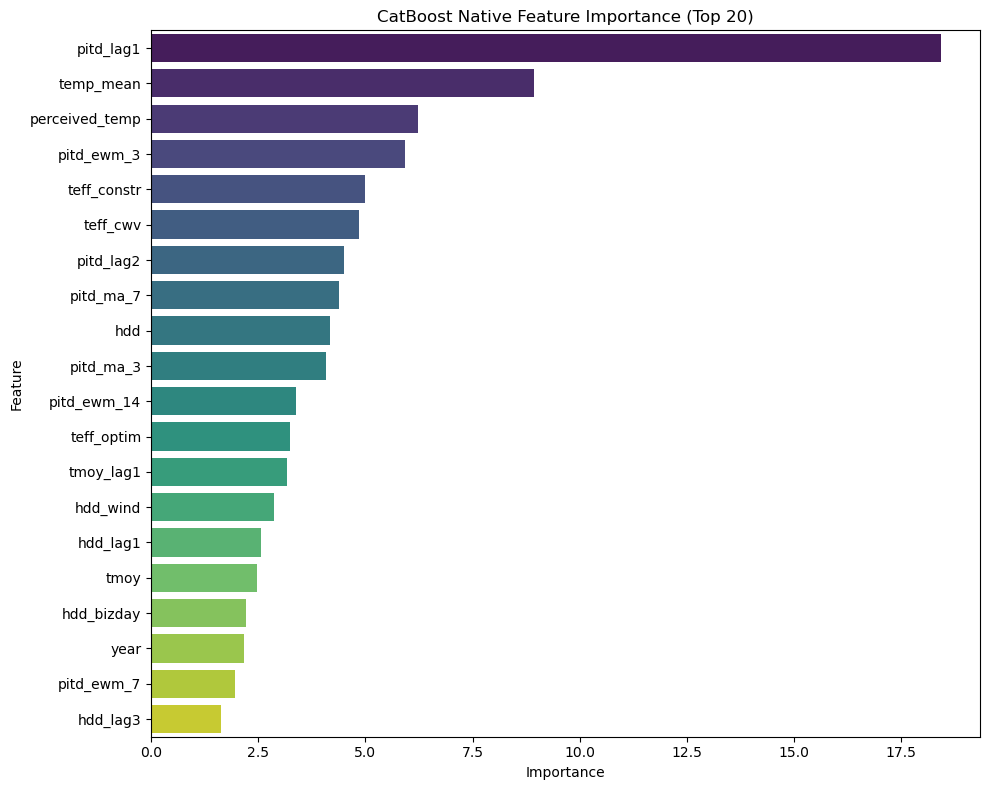


SHAP summaries & waterfall:


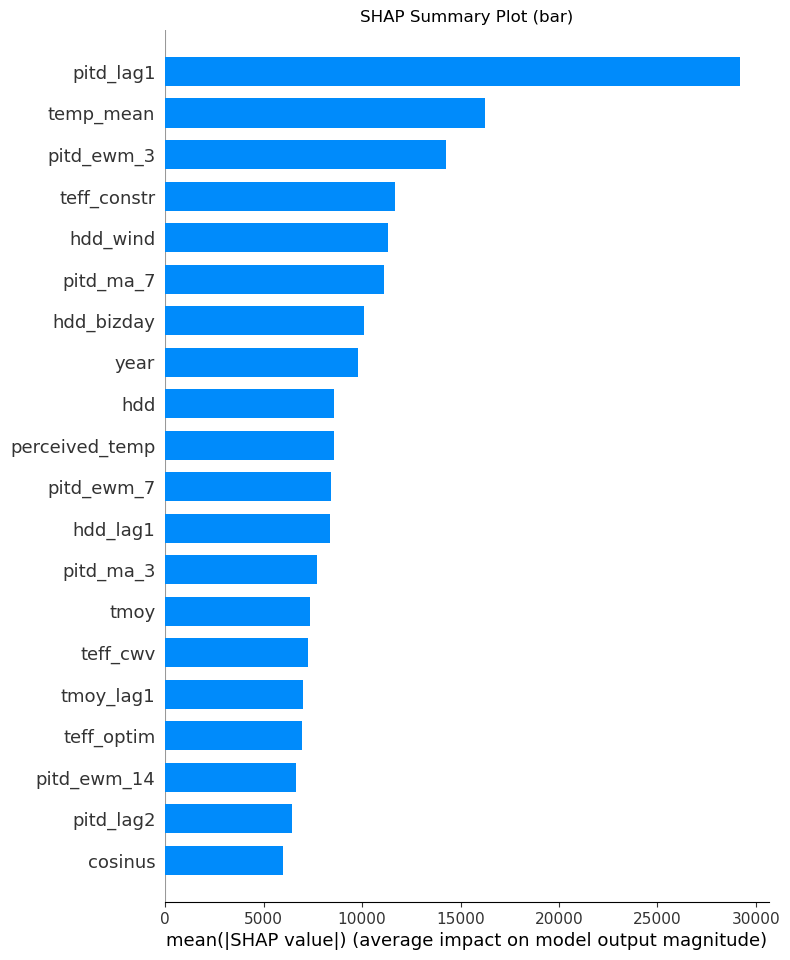

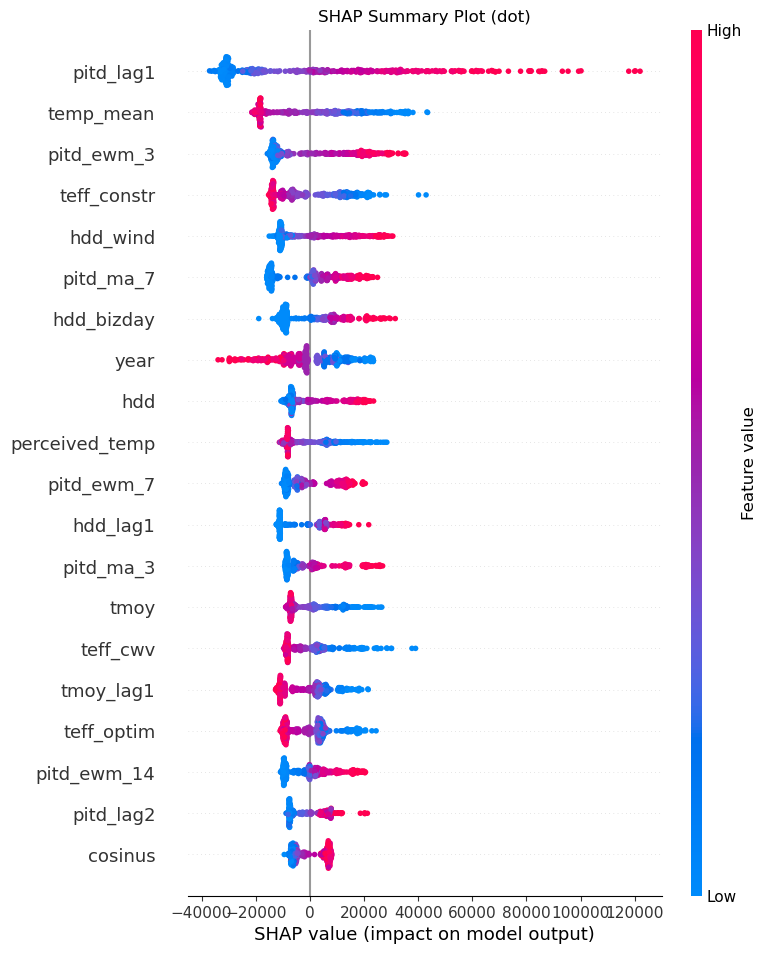

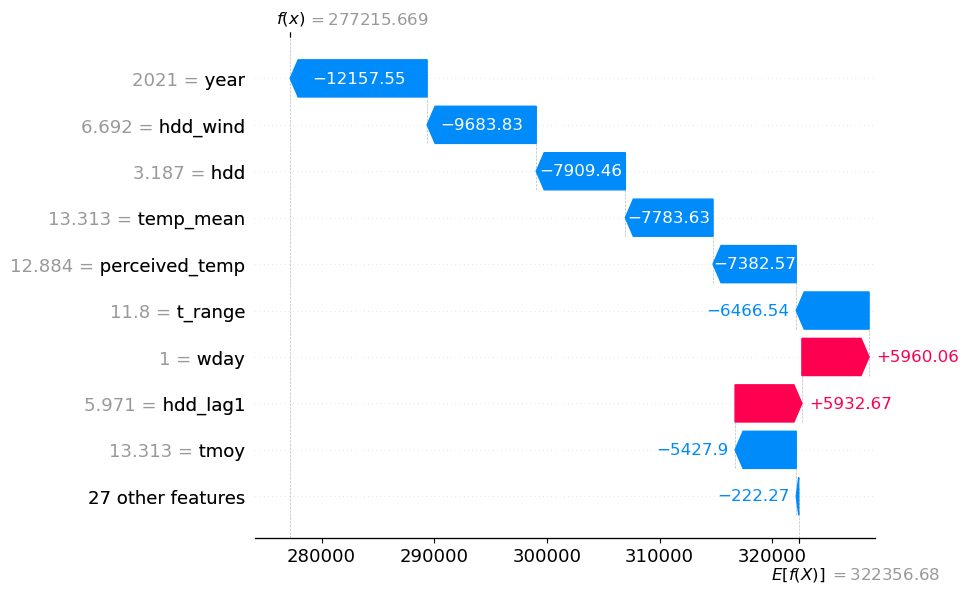

In [32]:
# %% Overall Model Comparison, Pairwise .compare(), and Best Model Analysis
from catboost import Pool, cv as catboost_cv
import pandas as pd
from utils import (
    plot_native_feature_importance,
    plot_shap_summary,
    plot_shap_waterfall
)



train_pool = Pool(data=X_rfecv, label=y_train, cat_features=cats_rfecv)
comparison_pool = Pool(data=X_rfecv_test, label=y_test, cat_features=cats_rfecv)

# 2) 10-Fold native CatBoost.cv per model
N_CV_EVAL_FOLDS = 5
models = {
    #"Default":   default_cb,
    #"TimeAware": time_cb,
    #"Golden":    golden_cb,
    "RS_tuned":  final_model_rs,
    "Optuna":    final_model_optuna_focused
}

model_cv_metrics = {}
for name, model in models.items():
    print(f"Running cv() for '{name}' …")
    raw = model.get_params()
    # only keep the keys cv() expects, plus our metrics
    keep = ['iterations','learning_rate','depth',
            'l2_leaf_reg','border_count',
            'has_time','boosting_type',
            'monotone_constraints']
    params = {k: raw[k] for k in keep if k in raw and raw[k] is not None}
    params.update({'loss_function': 'RMSE','eval_metric':'RMSE','custom_metric':['MAPE','R2']})

    cv_df = catboost_cv(
        pool=train_pool,
        params=params,
        fold_count=N_CV_EVAL_FOLDS,
        partition_random_seed=RANDOM_STATE,
        shuffle=True,
        as_pandas=True,
        verbose=False
    )
    # grab final row of means
    mean_rmse = cv_df['test-RMSE-mean'].iloc[-1]
    mean_mape = cv_df['test-MAPE-mean'].iloc[-1] * 100
    mean_r2   = cv_df['test-R2-mean'].iloc[-1]

    model_cv_metrics[name] = {'RMSE': mean_rmse, 'MAPE': mean_mape, 'R2': mean_r2}
    print(f"  → {name}: RMSE={mean_rmse:.4f}, MAPE={mean_mape:.2f}%, R²={mean_r2:.4f}\n")

comparison_df = pd.DataFrame(model_cv_metrics).T[['RMSE','MAPE','R2']]
print("Combined Model Performance (Mean CV Scores):")
print(comparison_df.sort_values('RMSE').to_string(float_format="%.4f"))

# 3) Pairwise .compare() on Test Set
print("\n--- Pairwise .compare() on Test Set ---")
names = list(models)
for i in range(len(names)):
    for j in range(i+1, len(names)):
        n1, n2 = names[i], names[j]
        print(f"\nComparing '{n1}' vs '{n2}' …")
        df_cmp = models[n1].compare(models[n2], comparison_pool, metrics=['RMSE'])
        #print(df_cmp[['metric_name','model1_wins','model2_wins','metric_value_diff']])
df_cmp
# 4) Pick best by CV RMSE & plot
best = comparison_df['RMSE'].idxmin()
print(f"\nSelected '{best}' as best model.")
final = models[best]

print("\nNative feature importance:")
plot_native_feature_importance(final, X_rfecv.columns.tolist())

print("\nSHAP summaries & waterfall:")
plot_shap_summary(final, X_rfecv_test, X_rfecv.columns.tolist(), plot_type="bar")
plot_shap_summary(final, X_rfecv_test, X_rfecv.columns.tolist(), plot_type="dot")
plot_shap_waterfall(final, X_rfecv_test, X_rfecv.columns.tolist(), instance_index=1)


HOLIDAYS only →  RMSE: 16630.67,  MAPE: 7.76%,  R²: 0.991


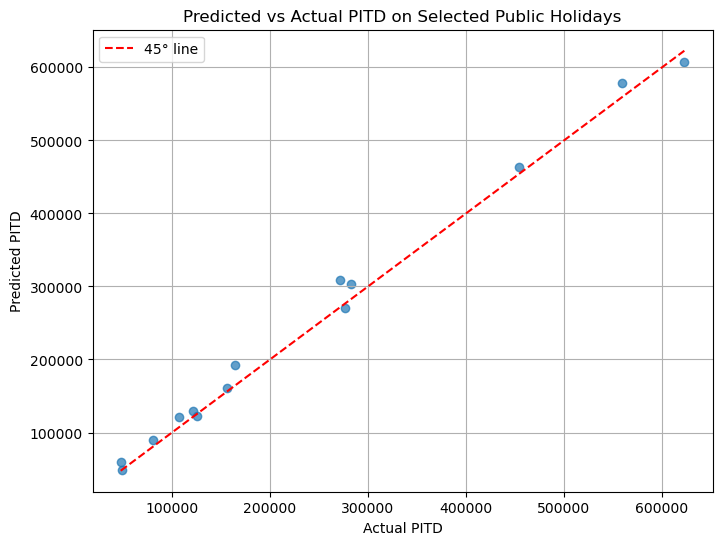

In [33]:
# %%  Holiday-only eval with index-aligned masking  ────────────────────
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# assume:
X_full_test    = X_test_sel

frholidays = [
    "NewYearsDay",
    "ChristmasDay",
    "EasterMonday",
    "PentecostMonday",
    "FRAscension",
    "LaborDay",
    "FRFetDeLaVictoire1945",
    "FRBastilleDay",
    "FRArmisticeDay",
    "FRAssumptionVirginMary",
    "FRAllSaints"
]

mask = X_full_test['public_holidays'].isin(frholidays)

# 3) slice out only those rows (by index) from y_test and X_rfecv_test
idx_hol = X_full_test.index[mask]
y_hol    = y_test.loc[   idx_hol ]
X_hol_rf = X_rfecv_test.loc[idx_hol]

# 4) predict & compute
yhat_hol = final.predict(X_hol_rf)
rmse_hol = np.sqrt(mean_squared_error(   y_hol, yhat_hol))
mape_hol = mean_absolute_percentage_error(y_hol, yhat_hol) * 100
r2_hol   = r2_score(                        y_hol, yhat_hol)

print(f"HOLIDAYS only →  RMSE: {rmse_hol:.2f},  MAPE: {mape_hol:.2f}%,  R²: {r2_hol:.3f}")

# 5) scatter
plt.figure(figsize=(8,6))
plt.scatter(y_hol, yhat_hol, alpha=0.7)
lims = [min(y_hol.min(), yhat_hol.min()), max(y_hol.max(), yhat_hol.max())]
plt.plot(lims, lims, 'r--', label='45° line')
plt.title('Predicted vs Actual PITD on Selected Public Holidays')
plt.xlabel('Actual PITD')
plt.ylabel('Predicted PITD')
plt.legend()
plt.grid(True)
plt.show()
# %%


In [34]:
# %%  Holiday-weighted re-train, manual CV & evaluation for RS and Optuna models  ⸺
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import KFold
from sklearn.base import clone

# 1) French holidays list
frholidays = [
    "NewYearsDay",
    "ChristmasDay",
    "EasterMonday",
    "PentecostMonday",
    "FRAscension",
    "LaborDay",
    "FRFetDeLaVictoire1945",
    "FRBastilleDay",
    "FRArmisticeDay",
    "FRAssumptionVirginMary",
    "FRAllSaints"
]

# 2) Prepare training and test frames with holiday flag
X_tr_full = Xfs_train[selected_rfecv].copy()
X_tr_full['public_holidays'] = Xfs_train['public_holidays']
X_te_full = Xfs_test[selected_rfecv].copy()
X_te_full['public_holidays']  = Xfs_test['public_holidays']
y_tr_full = y_train.copy()
y_te_full = y_test.copy()

# 3) Build sample weights (5× for specified holidays)
holiday_w, normal_w = 5, 1
w_tr = np.where(
    X_tr_full['public_holidays'].isin(frholidays),
    holiday_w,
    normal_w
)

# 4) Train weighted models on full training set using only RFECV features
rs_w = CatBoostRegressor(
    **best_params_random,
    loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE,
    cat_features=cats_rfecv, verbose=0
)
opt_w = CatBoostRegressor(
    **best_params_optuna_focused,
    loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE,
    cat_features=cats_rfecv, verbose=0
)
# fit using only selected features
rs_w.fit(
    X_tr_full[selected_rfecv],
    y_tr_full,
    sample_weight=w_tr
)
opt_w.fit(
    X_tr_full[selected_rfecv],
    y_tr_full,
    sample_weight=w_tr
)

# 5) Holiday-only evaluation on test set
mask_hol = X_te_full['public_holidays'].isin(frholidays)
X_hol = X_te_full.loc[mask_hol, selected_rfecv]
y_hol = y_te_full.loc[mask_hol]
print("\n--- Holiday-only Performance ---")
for name, m in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    pred = m.predict(X_hol)
    print(
        f"{name} → RMSE: {np.sqrt(mean_squared_error(y_hol, pred)):.2f}, "+
        f"MAPE: {mean_absolute_percentage_error(y_hol, pred)*100:.2f}%, "+
        f"R²: {r2_score(y_hol, pred):.3f}"
    )

# 6) Manual 5-Fold CV with sample weights
print("\n=== Manual 5-Fold CV Performance ===")
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, base_model in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    rmses, mapes, r2s = [], [], []
    for tr_idx, val_idx in cv.split(X_tr_full):
        X_tr, X_val = X_tr_full.iloc[tr_idx], X_tr_full.iloc[val_idx]
        y_tr, y_val = y_tr_full.iloc[tr_idx], y_tr_full.iloc[val_idx]
        w_tr_cv      = w_tr[tr_idx]
        model_cv     = clone(base_model)
        # fit on selected features only
        model_cv.fit(
            X_tr[selected_rfecv],
            y_tr,
            sample_weight=w_tr_cv
        )
        pred_val = model_cv.predict(X_val[selected_rfecv])
        rmses.append(np.sqrt(mean_squared_error(y_val, pred_val)))
        mapes.append(mean_absolute_percentage_error(y_val, pred_val)*100)
        r2s.append(r2_score(y_val, pred_val))
    print(
        f"{name} → RMSE: {np.mean(rmses):.2f}, "+
        f"MAPE: {np.mean(mapes):.2f}%, "+
        f"R²: {np.mean(r2s):.3f}"
    )
# %%



--- Holiday-only Performance ---
RS-weighted → RMSE: 15143.61, MAPE: 5.63%, R²: 0.993
Optuna-weighted → RMSE: 14832.57, MAPE: 6.88%, R²: 0.993

=== Manual 5-Fold CV Performance ===
RS-weighted → RMSE: 16829.78, MAPE: 4.74%, R²: 0.995
Optuna-weighted → RMSE: 16657.78, MAPE: 4.40%, R²: 0.995


In [129]:
# %%  Holiday-weighted re-train, Leave-One-Holiday-Out & General 5-Fold CV for RS and Optuna models  ⸺
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.base import clone
from sklearn.model_selection import KFold

# 1) French holidays list
frholidays = [
    "NewYearsDay",
    "ChristmasDay",
    "EasterMonday",
    "PentecostMonday",
    "FRAscension",
    "LaborDay",
    "FRFetDeLaVictoire1945",
    "FRBastilleDay",
    "FRArmisticeDay",
    "FRAssumptionVirginMary",
    "FRAllSaints"
]

# 2) Prepare training and test frames with holiday flag
X_tr_full = Xfs_train[selected_rfecv].copy()
X_tr_full['public_holidays'] = Xfs_train['public_holidays']
X_te_full = Xfs_test[selected_rfecv].copy()
X_te_full['public_holidays']  = Xfs_test['public_holidays']

# Preserve targets
y_tr_full = y_train.copy()
y_te_full = y_test.copy()

# 3) Build sample weights (5× for specified holidays)
holiday_w, normal_w = 10, 1
w_tr = np.where(
    X_tr_full['public_holidays'].isin(frholidays),
    holiday_w,
    normal_w
)

# 4) Instantiate weighted models
rs_w = CatBoostRegressor(
    **best_params_random,
    loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE,
    cat_features=cats_rfecv, verbose=0
)
opt_w = CatBoostRegressor(
    **best_params_optuna_focused,
    loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE,
    cat_features=cats_rfecv, verbose=0
)

# 5) Fit weighted models on full training set
rs_w.fit(
    X_tr_full[selected_rfecv],
    y_tr_full,
    sample_weight=w_tr
)
opt_w.fit(
    X_tr_full[selected_rfecv],
    y_tr_full,
    sample_weight=w_tr
)

# 6) Holiday-only evaluation on test set
mask_hol = X_te_full['public_holidays'].isin(frholidays)
X_hol     = X_te_full.loc[mask_hol, selected_rfecv]
y_hol     = y_te_full.loc[mask_hol]
print("\n--- Holiday-only Performance on Test Set ---")
for name, m in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    pred = m.predict(X_hol)
    print(
        f"{name} → RMSE: {np.sqrt(mean_squared_error(y_hol, pred)):.2f}, "+
        f"MAPE: {mean_absolute_percentage_error(y_hol, pred)*100:.2f}%, "+
        f"R²: {r2_score(y_hol, pred):.3f}"
    )

# 7) Leave-One-Holiday-Out CV on training holidays (RMSE & MAPE only)
print("=== Leave-One-Holiday-Out CV Performance (Holidays Only) ===")
hol_idx = X_tr_full.index[X_tr_full['public_holidays'].isin(frholidays)]
for name, base_model in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    rmses, mapes = [], []  # only RMSE & MAPE
    for idx in hol_idx:
        # train on all except this holiday and evaluate on it
        train_idx = X_tr_full.index.difference([idx])
        val_idx   = [idx]
        X_tr_cv = X_tr_full.loc[train_idx, selected_rfecv]
        y_tr_cv = y_tr_full.loc[train_idx]
        w_tr_cv = w_tr[np.isin(X_tr_full.index, train_idx)]
        X_val_cv = X_tr_full.loc[val_idx, selected_rfecv]
        y_val_cv = y_tr_full.loc[val_idx]

        model_cv = clone(base_model)
        model_cv.fit(
            X_tr_cv,
            y_tr_cv,
            sample_weight=w_tr_cv
        )
        pred_cv = model_cv.predict(X_val_cv)
        rmses.append(np.sqrt(mean_squared_error(y_val_cv, pred_cv)))
        mapes.append(mean_absolute_percentage_error(y_val_cv, pred_cv)*100)
    print(
        f"{name} LOO-holidays → RMSE: {np.mean(rmses):.2f}, "+
        f"MAPE: {np.mean(mapes):.2f}%"
    )

# 8) General 5-Fold CV on full training set
print("\n=== General 5-Fold CV Performance on Weighted Models ===")
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, base_model in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    rmses, mapes, r2s = [], [], []
    for tr_idx, val_idx in cv.split(X_tr_full):
        X_tr_cv = X_tr_full.iloc[tr_idx][selected_rfecv]
        y_tr_cv = y_tr_full.iloc[tr_idx]
        w_cv    = w_tr[tr_idx]
        X_val_cv = X_tr_full.iloc[val_idx][selected_rfecv]
        y_val_cv = y_tr_full.iloc[val_idx]

        model_cv = clone(base_model)
        model_cv.fit(
            X_tr_cv,
            y_tr_cv,
            sample_weight=w_cv
        )
        pred_val = model_cv.predict(X_val_cv)
        rmses.append(np.sqrt(mean_squared_error(y_val_cv, pred_val)))
        mapes.append(mean_absolute_percentage_error(y_val_cv, pred_val)*100)
        r2s.append(r2_score(y_val_cv, pred_val))
    print(
        f"{name} 5-Fold CV → RMSE: {np.mean(rmses):.2f}, "+
        f"MAPE: {np.mean(mapes):.2f}%, "+
        f"R²: {np.mean(r2s):.3f}"
    )
# %%



--- Holiday-only Performance on Test Set ---
RS-weighted → RMSE: 14462.30, MAPE: 5.78%, R²: 0.994
Optuna-weighted → RMSE: 15908.87, MAPE: 6.66%, R²: 0.992
=== Leave-One-Holiday-Out CV Performance (Holidays Only) ===
RS-weighted LOO-holidays → RMSE: 16825.80, MAPE: 9.81%
Optuna-weighted LOO-holidays → RMSE: 16681.88, MAPE: 9.56%

=== General 5-Fold CV Performance on Weighted Models ===
RS-weighted 5-Fold CV → RMSE: 17008.10, MAPE: 4.85%, R²: 0.994
Optuna-weighted 5-Fold CV → RMSE: 17000.43, MAPE: 4.55%, R²: 0.994


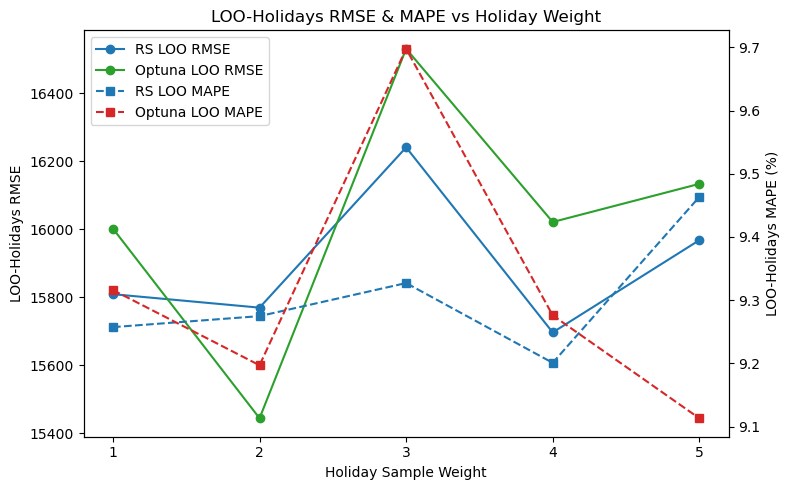

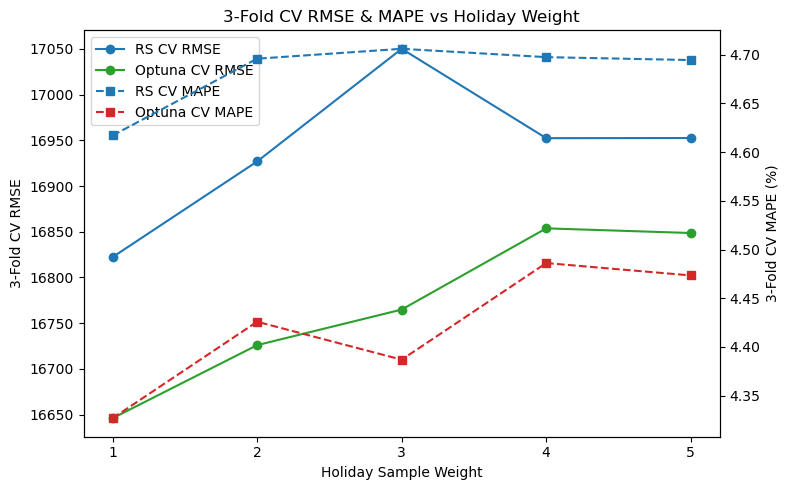

In [ ]:
## %%  Holiday‐Weight Sensitivity: LOO‐Holidays RMSE & MAPE vs Holiday Weight  ⸺
#import numpy as np
#import matplotlib.pyplot as plt
#from catboost import CatBoostRegressor
#from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
#from sklearn.base import clone
#
## French holidays list
#frholidays = [
#    "NewYearsDay", "ChristmasDay", "EasterMonday", "PentecostMonday",
#    "FRAscension", "LaborDay", "FRFetDeLaVictoire1945", "FRBastilleDay",
#    "FRArmisticeDay", "FRAssumptionVirginMary", "FRAllSaints"
#]
#
## Prepare full train frame & flags
#X_full = Xfs_train[selected_rfecv].copy()
#X_full['public_holidays'] = Xfs_train['public_holidays']
#y_full = y_train.copy()
#
## Define holiday weights to test
#weights = [1, 2, 3, 4, 5]
#
## Storage for results
#results = {
#    'RS': {'rmse': [], 'mape': []},
#    'Optuna': {'rmse': [], 'mape': []}
#}
#
## Loop over weights
#for w in weights:
#    # build sample weights array
#    sample_w = np.where(
#        X_full['public_holidays'].isin(frholidays),
#        w, 1
#    )
#    # instantiate fresh models
#    rs_model = CatBoostRegressor(
#        **best_params_random,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE,
#        cat_features=cats_rfecv, verbose=0
#    )
#    opt_model = CatBoostRegressor(
#        **best_params_optuna_focused,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE,
#        cat_features=cats_rfecv, verbose=0
#    )
#    # fit on full training (only RFECV features)
#    rs_model.fit(X_full[selected_rfecv], y_full, sample_weight=sample_w)
#    opt_model.fit(X_full[selected_rfecv], y_full, sample_weight=sample_w)
#
#    # Leave-One-Holiday-Out on training holidays
#    hol_idx = X_full.index[X_full['public_holidays'].isin(frholidays)]
#    rs_rmses, rs_mapes = [], []
#    opt_rmses, opt_mapes = [], []
#
#    for idx in hol_idx:
#        # train on all except this holiday
#        train_idx = X_full.index.difference([idx])
#        X_tr = X_full.loc[train_idx, selected_rfecv]
#        y_tr = y_full.loc[train_idx]
#        w_tr = sample_w[np.isin(X_full.index, train_idx)]
#
#        # val on the single holiday
#        X_val = X_full.loc[[idx], selected_rfecv]
#        y_val = y_full.loc[[idx]]
#
#        # RS
#        m_rs = clone(rs_model)
#        m_rs.fit(X_tr, y_tr, sample_weight=w_tr)
#        pred_rs = m_rs.predict(X_val)
#        rs_rmses.append(np.sqrt(mean_squared_error(y_val, pred_rs)))
#        rs_mapes.append(mean_absolute_percentage_error(y_val, pred_rs) * 100)
#
#        # Optuna
#        m_opt = clone(opt_model)
#        m_opt.fit(X_tr, y_tr, sample_weight=w_tr)
#        pred_opt = m_opt.predict(X_val)
#        opt_rmses.append(np.sqrt(mean_squared_error(y_val, pred_opt)))
#        opt_mapes.append(mean_absolute_percentage_error(y_val, pred_opt) * 100)
#
#    # store mean metrics
#    results['RS']['rmse'].append(np.mean(rs_rmses))
#    results['RS']['mape'].append(np.mean(rs_mapes))
#    results['Optuna']['rmse'].append(np.mean(opt_rmses))
#    results['Optuna']['mape'].append(np.mean(opt_mapes))
#
## Plotting LOO-Holidays metrics
#fig, ax1 = plt.subplots(figsize=(8,5))
#ax2 = ax1.twinx()
#
## RS curves
#ax1.plot(weights, results['RS']['rmse'], 'o-', label='RS LOO RMSE')
#ax2.plot(weights, results['RS']['mape'], 's--', label='RS LOO MAPE')
#
## Optuna curves
#ax1.plot(weights, results['Optuna']['rmse'], 'o-', label='Optuna LOO RMSE', color='C2')
#ax2.plot(weights, results['Optuna']['mape'], 's--', label='Optuna LOO MAPE', color='C3')
#
#ax1.set_xlabel('Holiday Sample Weight')
#ax1.set_ylabel('LOO-Holidays RMSE')
#ax2.set_ylabel('LOO-Holidays MAPE (%)')
#ax1.set_xticks(weights)
#lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
#plt.title('LOO-Holidays RMSE & MAPE vs Holiday Weight')
#plt.tight_layout()
#plt.show()
#
## 9) Overall 3-Fold CV Performance vs Weight
#from sklearn.model_selection import KFold
#
## Prepare storage for CV results
#results['RS']['cv_rmse'] = []
#results['RS']['cv_mape'] = []
#results['Optuna']['cv_rmse'] = []
#results['Optuna']['cv_mape'] = []
#
#kf3 = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
#for w in weights:
#    # rebuild sample weights
#    sample_w = np.where(
#        X_full['public_holidays'].isin(frholidays),
#        w, 1
#    )
#    # fresh models
#    rs_model = CatBoostRegressor(
#        **best_params_random,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE,
#        cat_features=cats_rfecv, verbose=0
#    )
#    opt_model = CatBoostRegressor(
#        **best_params_optuna_focused,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE,
#        cat_features=cats_rfecv, verbose=0
#    )
#    rmse_folds_rs, mape_folds_rs = [], []
#    rmse_folds_opt, mape_folds_opt = [], []
#    # 3-fold CV
#    for tr_i, val_i in kf3.split(X_full):
#        X_tr, X_val = X_full.iloc[tr_i][selected_rfecv], X_full.iloc[val_i][selected_rfecv]
#        y_tr, y_val = y_full.iloc[tr_i], y_full.iloc[val_i]
#        w_tr_cv = sample_w[tr_i]
#        # RS
#        m_rs = clone(rs_model)
#        m_rs.fit(X_tr, y_tr, sample_weight=w_tr_cv)
#        pred_rs = m_rs.predict(X_val)
#        rmse_folds_rs.append(np.sqrt(mean_squared_error(y_val, pred_rs)))
#        mape_folds_rs.append(mean_absolute_percentage_error(y_val, pred_rs)*100)
#        # Optuna
#        m_opt = clone(opt_model)
#        m_opt.fit(X_tr, y_tr, sample_weight=w_tr_cv)
#        pred_opt = m_opt.predict(X_val)
#        rmse_folds_opt.append(np.sqrt(mean_squared_error(y_val, pred_opt)))
#        mape_folds_opt.append(mean_absolute_percentage_error(y_val, pred_opt)*100)
#    # store mean
#    results['RS']['cv_rmse'].append(np.mean(rmse_folds_rs))
#    results['RS']['cv_mape'].append(np.mean(mape_folds_rs))
#    results['Optuna']['cv_rmse'].append(np.mean(rmse_folds_opt))
#    results['Optuna']['cv_mape'].append(np.mean(mape_folds_opt))
#
## Plotting 3-Fold CV metrics
#fig, ax1 = plt.subplots(figsize=(8,5))
#ax2 = ax1.twinx()
#
## RS
#ax1.plot(weights, results['RS']['cv_rmse'], 'o-', label='RS CV RMSE')
#ax2.plot(weights, results['RS']['cv_mape'], 's--', label='RS CV MAPE')
## Optuna
#ax1.plot(weights, results['Optuna']['cv_rmse'], 'o-', label='Optuna CV RMSE', color='C2')
#ax2.plot(weights, results['Optuna']['cv_mape'], 's--', label='Optuna CV MAPE', color='C3')
#
#ax1.set_xlabel('Holiday Sample Weight')
#ax1.set_ylabel('3-Fold CV RMSE')
#ax2.set_ylabel('3-Fold CV MAPE (%)')
#ax1.set_xticks(weights)
#lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
#plt.title('3-Fold CV RMSE & MAPE vs Holiday Weight')
#plt.tight_layout()
#plt.show()
## %%


weight = 2 appears to be the best compromise

In [ ]:
## %%  Oversample holidays in training set & eval  ⸺
#from catboost import CatBoostRegressor, Pool
#import numpy as np
#from sklearn.utils import shuffle
#from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
#
## 1) Choose oversampling factor (how many times to replicate holiday rows)
#OS_FACTOR = 5
#
## 2) Make full RFECV train frame with holiday flag
#X_train_os_full = X_tr_full[selected_rfecv].copy()
#X_train_os_full['is_hol'] = X_tr_full['public_holidays'].isin(frholidays).astype(int)
#y_train_os_full = y_tr_full.copy()
#
## 3) Split out holiday subset
#mask = X_train_os_full['is_hol'] == 1
#X_hol_subset = X_train_os_full.loc[mask, selected_rfecv]
#y_hol_subset = y_train_os_full.loc[mask]
#
## 4) Build oversampled train set by concatenation
#X_os = pd.concat(
#    [X_train_os_full[selected_rfecv]] +
#    [X_hol_subset[selected_rfecv]] * (OS_FACTOR - 1),
#    axis=0
#)
#y_os = pd.concat(
#    [y_train_os_full] +
#    [y_hol_subset] * (OS_FACTOR - 1),
#    axis=0
#)
#
## 2) Shuffle them together
#X_train_os, y_train_os = shuffle(X_os, y_os, random_state=RANDOM_STATE)
#
## 3) Re-instantiate oversampled models
#rs_os = CatBoostRegressor(
#    **best_params_random,
#    loss_function='RMSE',
#    eval_metric='RMSE',
#    random_seed=RANDOM_STATE,
#    cat_features=cats_rfecv,
#    verbose=0
#)
#opt_os = CatBoostRegressor(
#    **best_params_optuna_focused,
#    loss_function='RMSE',
#    eval_metric='RMSE',
#    random_seed=RANDOM_STATE,
#    cat_features=cats_rfecv,
#    verbose=0
#)
#
#
#rs_os.fit(X_train_os, y_train_os)
#opt_os.fit(X_train_os, y_train_os)
#
## 7) Evaluate on holidays in the **original** test set
#mask_test_hol = X_te_full['public_holidays'].isin(frholidays)
#X_test_hol    = X_te_full.loc[mask_test_hol, selected_rfecv]
#y_test_hol    = y_te_full.loc[mask_test_hol]
#
#print("\n--- Oversampled Holiday Test Performance ---")
#for name, m in [('RS-Oversampled', rs_os), ('Optuna-Oversampled', opt_os)]:
#    pred = m.predict(X_test_hol)
#    print(
#        f"{name} → RMSE: {np.sqrt(mean_squared_error(y_test_hol, pred)):.2f}, "+
#        f"MAPE: {mean_absolute_percentage_error(y_test_hol, pred)*100:.2f}%, "+
#        f"R²: {r2_score(y_test_hol, pred):.3f}"
#    )
#
## 8) (Optional) Quick 3-fold CV on oversampled train set
#from sklearn.model_selection import KFold
#kf3 = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
#
#print("\n=== 3-Fold CV on Oversampled Data ===")
#for name, base_model in [('RS-Oversampled', rs_os), ('Optuna-Oversampled', opt_os)]:
#    rmses, mapes = [], []
#    for tr_i, val_i in kf3.split(X_train_os):
#        X_tr, X_val = X_train_os.iloc[tr_i], X_train_os.iloc[val_i]
#        y_tr, y_val = y_train_os.iloc[tr_i], y_train_os.iloc[val_i]
#        m_cv = clone(base_model)
#        m_cv.fit(X_tr, y_tr)
#        p = m_cv.predict(X_val)
#        rmses.append(np.sqrt(mean_squared_error(y_val, p)))
#        mapes.append(mean_absolute_percentage_error(y_val, p)*100)
#    print(f"{name} → RMSE: {np.mean(rmses):.2f}, MAPE: {np.mean(mapes):.2f}%")
## %%



--- Oversampled Holiday Test Performance ---
RS-Oversampled → RMSE: 18750.89, MAPE: 6.85%, R²: 0.989
Optuna-Oversampled → RMSE: 12989.50, MAPE: 5.97%, R²: 0.995

=== 3-Fold CV on Oversampled Data ===
RS-Oversampled → RMSE: 15766.28, MAPE: 4.53%
Optuna-Oversampled → RMSE: 14945.19, MAPE: 3.76%


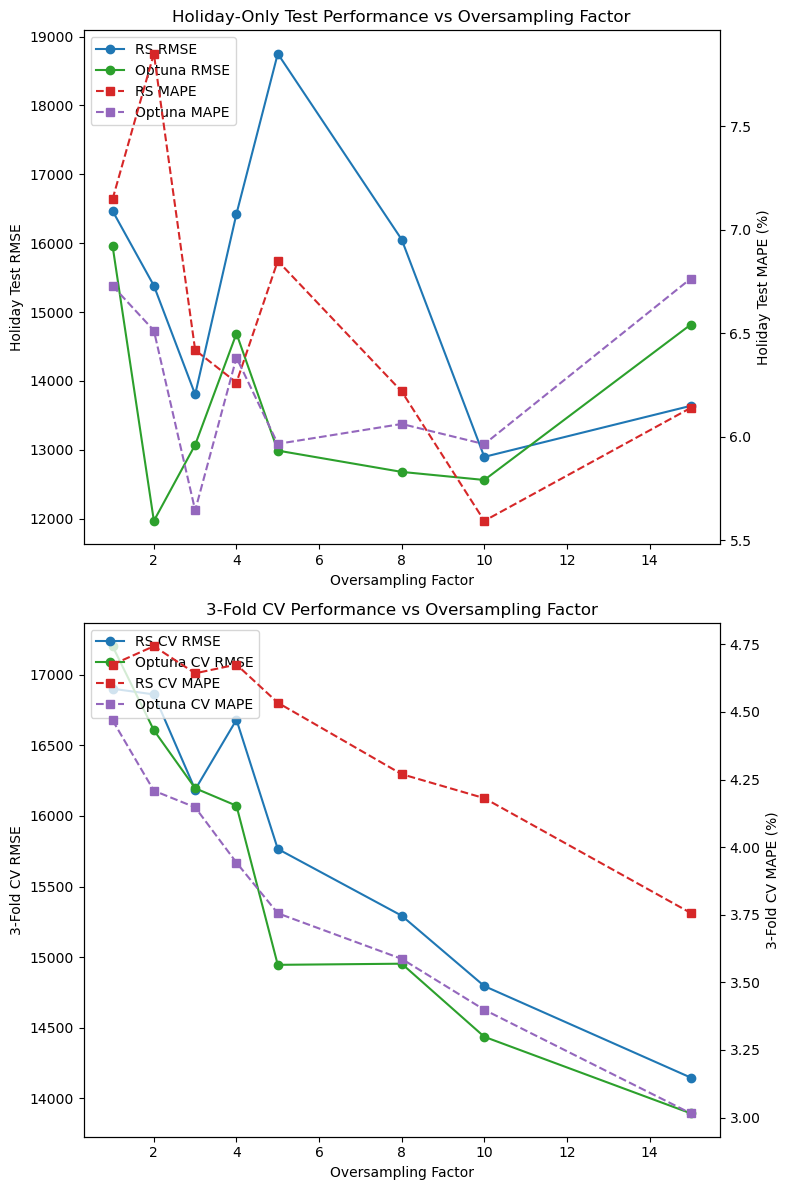

In [ ]:
## %%  Oversampling Sensitivity Analysis & Plots  ⸺
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.utils import shuffle
#from sklearn.model_selection import KFold
#from catboost import CatBoostRegressor
#from sklearn.base import clone
#from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
#
## 1) French holidays list
#frholidays = [
#    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
#    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
#    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
#]
#
## 2) Prepare full RFECV train & test frames
##    (assumes X_tr_full, X_te_full, y_tr_full, y_te_full already exist)
## X_tr_full has columns selected_rfecv + 'public_holidays'
## X_te_full likewise, y_tr_full = y_train, y_te_full = y_test
#
## 3) Define oversampling factors to test
#os_factors = [1, 2, 3, 4, 5, 8, 10, 15]
#
## 4) Build holiday‐only test set once
#mask_te_hol = X_te_full['public_holidays'].isin(frholidays)
#X_test_hol  = X_te_full.loc[mask_te_hol, selected_rfecv]
#y_test_hol  = y_te_full.loc[mask_te_hol]
#
## 5) Storage for all metrics
#records = {
#    'factor': [],
#    'RS_test_rmse': [], 'RS_test_mape': [],
#    'Opt_test_rmse': [], 'Opt_test_mape': [],
#    'RS_cv_rmse': [],   'RS_cv_mape': [],
#    'Opt_cv_rmse': [],  'Opt_cv_mape': []
#}
#
## 6) Loop over oversampling factors
#for f in os_factors:
#    # a) build oversampled train set via concat
#    #    replicate only the holiday rows (public_holidays ∈ frholidays)
#    X_hol = X_tr_full[X_tr_full['public_holidays'].isin(frholidays)][selected_rfecv]
#    y_hol = y_tr_full[X_tr_full['public_holidays'].isin(frholidays)]
#    X_os = pd.concat([X_tr_full[selected_rfecv]] + [X_hol] * (f - 1), axis=0)
#    y_os = pd.concat([y_tr_full]           + [y_hol] * (f - 1), axis=0)
#    X_os, y_os = shuffle(X_os, y_os, random_state=RANDOM_STATE)
#
#    # b) instantiate models with your tuned settings
#    rs_model = CatBoostRegressor(
#        **best_params_random,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE, cat_features=cats_rfecv, verbose=0
#    )
#    opt_model = CatBoostRegressor(
#        **best_params_optuna_focused,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE, cat_features=cats_rfecv, verbose=0
#    )
#
#    # c) fit on oversampled training data
#    rs_model.fit(X_os, y_os)
#    opt_model.fit(X_os, y_os)
#
#    # d) evaluate on holiday‐only test set
#    pred_rs = rs_model.predict(X_test_hol)
#    pred_opt = opt_model.predict(X_test_hol)
#    rs_trmse = np.sqrt(mean_squared_error(y_test_hol, pred_rs))
#    rs_tmape = mean_absolute_percentage_error(y_test_hol, pred_rs) * 100
#    opt_trmse = np.sqrt(mean_squared_error(y_test_hol, pred_opt))
#    opt_tmape = mean_absolute_percentage_error(y_test_hol, pred_opt) * 100
#
#    # e) 3‐fold CV on oversampled data (whole set)
#    kf3 = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
#    rs_cvres, rs_cvmap = [], []
#    opt_cvres, opt_cvmap = [], []
#    for tr_i, val_i in kf3.split(X_os):
#        X_tr, y_tr = X_os.iloc[tr_i], y_os.iloc[tr_i]
#        X_val, y_val = X_os.iloc[val_i], y_os.iloc[val_i]
#
#        m_rs = clone(rs_model)
#        m_rs.fit(X_tr, y_tr)
#        p_rs = m_rs.predict(X_val)
#        rs_cvres.append(np.sqrt(mean_squared_error(y_val, p_rs)))
#        rs_cvmap.append(mean_absolute_percentage_error(y_val, p_rs) * 100)
#
#        m_opt = clone(opt_model)
#        m_opt.fit(X_tr, y_tr)
#        p_opt = m_opt.predict(X_val)
#        opt_cvres.append(np.sqrt(mean_squared_error(y_val, p_opt)))
#        opt_cvmap.append(mean_absolute_percentage_error(y_val, p_opt) * 100)
#
#    # f) record means
#    records['factor'].append(f)
#    records['RS_test_rmse'].append(rs_trmse)
#    records['RS_test_mape'].append(rs_tmape)
#    records['Opt_test_rmse'].append(opt_trmse)
#    records['Opt_test_mape'].append(opt_tmape)
#    records['RS_cv_rmse'].append(np.mean(rs_cvres))
#    records['RS_cv_mape'].append(np.mean(rs_cvmap))
#    records['Opt_cv_rmse'].append(np.mean(opt_cvres))
#    records['Opt_cv_mape'].append(np.mean(opt_cvmap))
#
## 7) Convert to DataFrame
#df_rec = pd.DataFrame(records)
#
## 8) Plotting
#fig, axes = plt.subplots(2, 1, figsize=(8, 12))
## ─ Holiday‐Test Performance ─────────────────────────────────────────
#ax1 = axes[0]
#ax2 = ax1.twinx()
#ax1.plot(df_rec['factor'], df_rec['RS_test_rmse'], 'o-', label='RS RMSE')
#ax1.plot(df_rec['factor'], df_rec['Opt_test_rmse'], 'o-', label='Optuna RMSE', color='C2')
#ax2.plot(df_rec['factor'], df_rec['RS_test_mape'], 's--', label='RS MAPE', color='C3')
#ax2.plot(df_rec['factor'], df_rec['Opt_test_mape'], 's--', label='Optuna MAPE', color='C4')
#ax1.set_xlabel('Oversampling Factor')
#ax1.set_ylabel('Holiday Test RMSE')
#ax2.set_ylabel('Holiday Test MAPE (%)')
#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()
#ax1.legend(h1 + h2, l1 + l2, loc='upper left')
#ax1.set_title('Holiday‐Only Test Performance vs Oversampling Factor')
#
## ─ 3‐Fold CV Performance ────────────────────────────────────────────
#ax3 = axes[1]
#ax4 = ax3.twinx()
#ax3.plot(df_rec['factor'], df_rec['RS_cv_rmse'], 'o-', label='RS CV RMSE')
#ax3.plot(df_rec['factor'], df_rec['Opt_cv_rmse'], 'o-', label='Optuna CV RMSE', color='C2')
#ax4.plot(df_rec['factor'], df_rec['RS_cv_mape'], 's--', label='RS CV MAPE', color='C3')
#ax4.plot(df_rec['factor'], df_rec['Opt_cv_mape'], 's--', label='Optuna CV MAPE', color='C4')
#ax3.set_xlabel('Oversampling Factor')
#ax3.set_ylabel('3-Fold CV RMSE')
#ax4.set_ylabel('3-Fold CV MAPE (%)')
#h3, l3 = ax3.get_legend_handles_labels()
#h4, l4 = ax4.get_legend_handles_labels()
#ax3.legend(h3 + h4, l3 + l4, loc='upper left')
#ax3.set_title('3‐Fold CV Performance vs Oversampling Factor')
#
#plt.tight_layout()
#plt.show()
# %%


In [ ]:
## %%  Proper Oversampling inside 3-Fold CV  ⸺
#import numpy as np
#from sklearn.model_selection import KFold
#from imblearn.over_sampling import RandomOverSampler
#from catboost import CatBoostRegressor
#from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
#
## 1) CV setup
#kf3 = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
#
## 2) Features & categorical spec
#feat = selected_rfecv + ['public_holidays']
#cats = [c for c in feat if c in cats_rfecv or c=='public_holidays']
#num_cols = [c for c in feat if c not in cats]
#jitter_std = 1
#
## 3) Collect per-fold holiday-only metrics
#rs_fold_rmse, rs_fold_mape = [], []
#opt_fold_rmse, opt_fold_mape = [], []
#
#for tr_idx, val_idx in kf3.split(X_tr_full):
#    # split raw
#    X_tr = X_tr_full.iloc[tr_idx][feat]
#    y_tr = y_tr_full.iloc[tr_idx]
#    X_val = X_tr_full.iloc[val_idx][feat]
#    y_val = y_tr_full.iloc[val_idx]
#
#    # build holiday flag (0/1)
#    is_hol = X_tr['public_holidays'].isin(frholidays).astype(int).values
#
#    # oversample indices
#    idxs = X_tr.index.values.reshape(-1,1)
#    ros = RandomOverSampler(
#        sampling_strategy={0: len(idxs), 1: len(idxs)},
#        random_state=RANDOM_STATE
#    )
#    idx_res, _ = ros.fit_resample(idxs, is_hol)
#    idx_res = idx_res.flatten()
#
#    # re-index into X/y and jitter
#    X_ros = X_tr_full.loc[idx_res, feat].copy()
#    y_ros = y_tr_full.loc[idx_res].copy()
#    for col in num_cols:
#        X_ros[col] += np.random.normal(0, jitter_std, size=len(X_ros))
#
#    # train both models
#    rs_cv = CatBoostRegressor(
#        **best_params_random,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE, cat_features=cats, verbose=0
#    )
#    opt_cv = CatBoostRegressor(
#        **best_params_optuna_focused,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE, cat_features=cats, verbose=0
#    )
#    rs_cv.fit(X_ros, y_ros)
#    opt_cv.fit(X_ros, y_ros)
#
#    # evaluate on this fold’s holiday subset of validation
#    mask_vh = X_val['public_holidays'].isin(frholidays)
#    X_val_h = X_val.loc[mask_vh, feat]
#    y_val_h = y_val.loc[mask_vh]
#
#    p_rs  = rs_cv.predict(X_val_h)
#    p_opt = opt_cv.predict(X_val_h)
#
#    rs_fold_rmse.append(np.sqrt(mean_squared_error(y_val_h, p_rs)))
#    rs_fold_mape.append(mean_absolute_percentage_error(y_val_h, p_rs)*100)
#    opt_fold_rmse.append(np.sqrt(mean_squared_error(y_val_h, p_opt)))
#    opt_fold_mape.append(mean_absolute_percentage_error(y_val_h, p_opt)*100)
#
## 4) Report
#print(f"ROS-CV holidays → RS RMSE={np.mean(rs_fold_rmse):.2f}, MAPE={np.mean(rs_fold_mape):.2f}%")
#print(f"ROS-CV holidays → Opt RMSE={np.mean(opt_fold_rmse):.2f}, MAPE={np.mean(opt_fold_mape):.2f}%")


ROS-CV holidays → RS RMSE=20680.08, MAPE=6.56%
ROS-CV holidays → Opt RMSE=20174.41, MAPE=6.70%


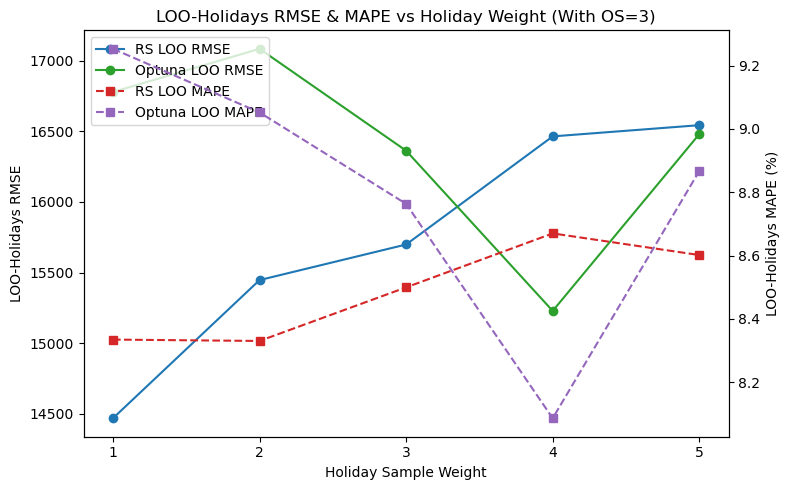

In [141]:
# %%  Combine Oversampling (×3) and Weight-Sensitivity on LOO-Holidays  ⸺
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone

# 1) French holidays list
frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

# 2) Build the base DataFrame with an 'orig_idx' to track duplicates
X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
X_base['orig_idx'] = X_base.index
y_base = y_train.copy()

# 3) Oversample holiday rows by factor 3
OS_FACTOR = 3
hol_mask = X_base['public_holidays'].isin(frholidays)
X_hol = X_base.loc[hol_mask]
y_hol = y_base.loc[hol_mask]

X_os = pd.concat([X_base] + [X_hol]*(OS_FACTOR-1), axis=0).reset_index(drop=True)
y_os = pd.concat([y_base] + [y_hol]*(OS_FACTOR-1), axis=0).reset_index(drop=True)

# 4) Prepare the range of holiday sample-weights to test
weights = [1, 2, 3, 4, 5]

# 5) Storage for LOO metrics
loo = {'RS': {'rmse':[], 'mape':[]}, 'Optuna': {'rmse':[], 'mape':[]}}

for w in weights:
    # a) build sample_weight vector over the oversampled set
    sw = np.where(X_os['public_holidays'].isin(frholidays), w, 1)
    
    # b) instantiate fresh models
    rs = CatBoostRegressor(
        **best_params_random,
        loss_function='RMSE', eval_metric='RMSE',
        random_seed=RANDOM_STATE,
        cat_features=cats_rfecv, verbose=0
    )
    opt = CatBoostRegressor(
        **best_params_optuna_focused,
        loss_function='RMSE', eval_metric='RMSE',
        random_seed=RANDOM_STATE,
        cat_features=cats_rfecv, verbose=0
    )
    
    # c) fit on the oversampled training set
    rs.fit(X_os[selected_rfecv], y_os, sample_weight=sw)
    opt.fit(X_os[selected_rfecv], y_os, sample_weight=sw)
    
    # d) Leave-One-Holiday-Out on the *original* holidays
    orig_hol_idxs = X_base.index[ X_base['public_holidays'].isin(frholidays) ]
    rs_errs, rs_maps = [], []
    op_errs, op_maps = [], []
    
    for idx in orig_hol_idxs:
        # train on all OS rows whose orig_idx ≠ idx
        train_mask = X_os['orig_idx'] != idx
        X_tr = X_os.loc[train_mask, selected_rfecv]
        y_tr = y_os[train_mask]
        sw_tr = sw[train_mask]
        
        # validate on the single original holiday row
        X_val = X_base.loc[[idx], selected_rfecv]
        y_val = y_base.loc[[idx]]
        
        # clone, refit & predict
        mrs = clone(rs)
        mrs.fit(X_tr, y_tr, sample_weight=sw_tr)
        p_rs = mrs.predict(X_val)
        rs_errs.append(np.sqrt(mean_squared_error(y_val, p_rs)))
        rs_maps.append(mean_absolute_percentage_error(y_val, p_rs)*100)
        
        mop = clone(opt)
        mop.fit(X_tr, y_tr, sample_weight=sw_tr)
        p_op = mop.predict(X_val)
        op_errs.append(np.sqrt(mean_squared_error(y_val, p_op)))
        op_maps.append(mean_absolute_percentage_error(y_val, p_op)*100)
    
    loo['RS']['rmse'].append(np.mean(rs_errs))
    loo['RS']['mape'].append(np.mean(rs_maps))
    loo['Optuna']['rmse'].append(np.mean(op_errs))
    loo['Optuna']['mape'].append(np.mean(op_maps))

# 6) Plot LOO-Holidays RMSE & MAPE vs Holiday Weight (with OS×3)
fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

ax1.plot(weights, loo['RS']['rmse'],  'o-', label='RS LOO RMSE')
ax1.plot(weights, loo['Optuna']['rmse'], 'o-', color='C2', label='Optuna LOO RMSE')
ax2.plot(weights, loo['RS']['mape'],  's--', color='C3', label='RS LOO MAPE')
ax2.plot(weights, loo['Optuna']['mape'], 's--', color='C4', label='Optuna LOO MAPE')

ax1.set_xlabel('Holiday Sample Weight')
ax1.set_ylabel('LOO-Holidays RMSE')
ax2.set_ylabel('LOO-Holidays MAPE (%)')
ax1.set_xticks(weights)
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')
plt.title('LOO-Holidays RMSE & MAPE vs Holiday Weight (With OS=3)')
plt.tight_layout()
plt.show()


In [144]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1) Build your OS×3 training set (exactly like before)
OS_FACTOR = 3
hol_mask   = Xfs_train['public_holidays'].isin(frholidays)
X_hol      = Xfs_train[hol_mask]
y_hol      = y_train[hol_mask]

X_os = pd.concat([Xfs_train] + [X_hol]*(OS_FACTOR-1), axis=0).reset_index(drop=True)
y_os = pd.concat([y_train]   + [y_hol]*(OS_FACTOR-1), axis=0).reset_index(drop=True)

# 2) Precompute a sample_weight array over that oversampled set
#    (e.g. holiday rows get weight=5, normal=1)
weight_value = 5
sw = np.where(
    X_os['public_holidays'].isin(frholidays),
    weight_value,  # holiday weight
    1              # normal-day weight
)

# 3) Plug into RandomizedSearchCV
base_cb = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=RANDOM_STATE,
    cat_features=cats_rfecv,
    verbose=0
)


param_dist = {
    'iterations': randint(1000, 2500),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(2, 8),
    'l2_leaf_reg': uniform(1, 5),
    'border_count': randint(126, 256),
    'per_float_feature_quantization': quantisation_candidates,
    'monotone_constraints':             monotone_constraint_candidates,
    }

rs_cv = RandomizedSearchCV(
    estimator=base_cb,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    verbose=1
)

# **this** is the key: pass sample_weight here
rs_cv.fit(
    X_os[selected_rfecv], 
    y_os, 
    sample_weight=sw
)

print("Best parameters:", rs_cv.best_params_)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'border_count': 177, 'depth': 5, 'iterations': 2409, 'l2_leaf_reg': np.float64(4.56135294962221), 'learning_rate': np.float64(0.03961738599067998), 'monotone_constraints': {}, 'per_float_feature_quantization': ['17:border_count=1024', '16:border_count=1024']}


In [ ]:
from sklearn.model_selection import train_test_split

# 1) your list of true holidays
frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

# 2) build X_base & y_base (your full RFECV‐features frame and its target)
X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
y_base = y_train.copy()

# 3) collapse all non‐holidays into “NotAHoliday”
stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

# 4) now split *that* into 80/20, stratifying on your 12 classes
X_tr, X_te, y_tr, y_te = train_test_split(
    X_base[selected_rfecv],  # just your RFECV columns
    y_base, 
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

# 5) sanity check that every holiday made it into the test fold
print("Holidays in test set:",
      sorted(X_te
             .assign(holiday=X_te.index.map(lambda i: X_base.loc[i,'public_holidays']))
             ['holiday']
             .unique()))


In [65]:
import json
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# 1) load your tuned params
with open('best_params_hol.json','r') as f:
    best_rs_tuned = json.load(f)

# 2) define your holiday list
frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

# 3) build X_base & y_base (RFECV features + holiday label)
X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
y_base = y_train.copy()

# 4) make a stratify label: every true holiday stays as‐is, all others → "NotAHoliday"
stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

# 5) 80/20 split, stratifying on that label
X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

# 6) oversample **only** the holiday rows in the train‐fold ×3
OS = 3
mask_tr = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr = X_tr_base.loc[mask_tr]
y_hol_tr = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)

# 7) build your holiday‐weighted vector (5 for holidays, 1 otherwise)
sw = np.where(X_tr_os['public_holidays'].isin(frholidays), 5, 1)

# 8) slice out the **holiday‐only** slice of your **test‐fold**
mask_te_hol = X_te_base['public_holidays'].isin(frholidays)
X_te_hol    = X_te_base.loc[mask_te_hol,    selected_rfecv]
y_te_hol    = y_te_base.loc[mask_te_hol]

# 9) full‐test‐fold features + target
X_te_full = X_te_base[selected_rfecv]
y_te_full = y_te_base

# 10) instantiate & fit
model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    custom_metric=['MAPE','R2'],
    random_seed=RANDOM_STATE,
    cat_features=cats_rfecv,
    verbose=0,
    **best_rs_tuned
)

model.fit(
    X_tr_os[selected_rfecv], 
    y_tr_os, 
    sample_weight=sw,
    eval_set=[
      (X_te_full, y_te_full),   # your full 20% hold‐out
      (X_te_hol,  y_te_hol )    # the holiday‐only slice of that hold‐out
    ],
    use_best_model=True,
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1) holiday mask on your test-fold (must be the same frame you passed into model.fit as the full hold-out)
mask_te_hol = X_te_base['public_holidays'].isin(frholidays)

# 2) slice out the features & target for just those holiday rows
X_hol = X_te_base.loc[mask_te_hol, selected_rfecv]
y_hol = y_te_base.loc[mask_te_hol]

# 3) predict
preds_hol = model.predict(X_hol)

# 4) build a DataFrame tying together holiday name, true & predicted
df_hol = pd.DataFrame({
    'holiday': X_te_base.loc[mask_te_hol, 'public_holidays'].astype(str),
    'y_true':  y_hol.values,
    'y_pred':  preds_hol
})

# 5) sanity check: which holiday labels actually appear in your hold-out?
print("Holidays present in test set:", np.unique(df_hol['holiday']))

# 6) group by holiday name and compute RMSE & MAPE
per_holiday_eval = df_hol.groupby('holiday').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y_true'], g['y_pred'])),
        'mape': mean_absolute_percentage_error(g['y_true'], g['y_pred'])*100
    })
)

per_holiday_eval


Holidays present in test set: ['ChristmasDay' 'EasterMonday' 'FRAllSaints' 'FRArmisticeDay'
 'FRAscension' 'FRAssumptionVirginMary' 'FRBastilleDay'
 'FRFetDeLaVictoire1945' 'LaborDay' 'NewYearsDay' 'PentecostMonday']


,rmse,mape
holiday,,
ChristmasDay,24793.415199,4.983591
EasterMonday,25276.949449,6.355438
FRAllSaints,32536.652555,6.844209
FRArmisticeDay,10051.643484,2.472012
FRAscension,23930.503811,10.994530
FRAssumptionVirginMary,12535.405592,26.227775
FRBastilleDay,6229.732141,9.288022
FRFetDeLaVictoire1945,4826.553702,4.682208
LaborDay,53696.812080,18.465890


In [67]:
import json
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold

# 1) load your tuned RS params
with open('best_params_hol.json','r') as f:
    best_rs_tuned = json.load(f)


# 6) add orig_idx to track clones
X_tr_base = X_tr_base.copy()
X_tr_base['orig_idx'] = X_tr_base.index

# 7) oversample **only** the train-fold holidays ×3
OS = 3
mask_tr = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr = X_tr_base.loc[mask_tr]
y_hol_tr = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)

# 8) holiday weights: 5 for holidays, 1 for normal
sw = np.where(X_tr_os['public_holidays'].isin(frholidays), 5, 1)

# 9) train your tuned CatBoost on OS×3 + weights
rs = CatBoostRegressor(cat_features=cats_rfecv, verbose=0, **best_rs_tuned)
rs.fit(X_tr_os[selected_rfecv], y_tr_os, sample_weight=sw)

# ----- Leave-One-Holiday-Out on the **train** fold -----
errs_rmse, errs_mape = [], []
for idx in X_tr_base.loc[mask_tr, 'orig_idx']:
    # drop all clones of that holiday
    train_mask = X_tr_os['orig_idx'] != idx

    X_tr = X_tr_os.loc[train_mask, selected_rfecv]
    y_tr = y_tr_os[train_mask]
    sw_tr = sw[train_mask]

    X_val = X_tr_base.loc[X_tr_base['orig_idx']==idx, selected_rfecv]
    y_val = y_tr_base.loc[[idx]]

    m = clone(rs)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_val)

    errs_rmse.append(np.sqrt(mean_squared_error(y_val, p)))
    errs_mape.append(mean_absolute_percentage_error(y_val, p)*100)

loo_rmse = np.mean(errs_rmse)
loo_mape = np.mean(errs_mape)
print(f"LOO-Holidays → RMSE: {loo_rmse:.2f}, MAPE: {loo_mape:.2f}%")

# ----- 5-Fold CV on the **same** OS×3 weighted train set -----
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse, cv_mape = [], []

for tr_idx, va_idx in kf.split(X_tr_os):
    X_tr = X_tr_os.iloc[tr_idx][selected_rfecv]
    y_tr = y_tr_os.iloc[tr_idx]
    sw_tr = sw[tr_idx]

    X_va = X_tr_os.iloc[va_idx][selected_rfecv]
    y_va = y_tr_os.iloc[va_idx]

    m = clone(rs)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    cv_rmse.append(np.sqrt(mean_squared_error(y_va, p)))
    cv_mape.append(mean_absolute_percentage_error(y_va, p)*100)

print(f"5-Fold CV → RMSE: {np.mean(cv_rmse):.2f}, MAPE: {np.mean(cv_mape):.2f}%")


LOO-Holidays → RMSE: 16853.62, MAPE: 9.17%
5-Fold CV → RMSE: 16555.05, MAPE: 4.22%


In [55]:
## 1) load your tuned params
#import json
#with open('best_params_hol.json','r') as f:
#    best_rs_tuned = json.load(f)
#
## 2) define your holiday list
#frholidays = [
#    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
#    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
#    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
#]
#
## 3) build X_base & y_base (the RFECV train split)
#X_base = Xfs_train[selected_rfecv].copy()
#X_base['public_holidays'] = Xfs_train['public_holidays']
#y_base = y_train.copy()
#
## 4) oversample only the training holidays ×3
#OS = 3
#mask = X_base['public_holidays'].isin(frholidays)
#X_os = pd.concat([X_base] + [X_base[mask]]*(OS-1), axis=0).reset_index(drop=True)
#y_os = pd.concat([y_base] + [y_base[mask]]*(OS-1), axis=0).reset_index(drop=True)
## 1) define your holiday mask on the test frame, not the train one:
#mask_te_hol = X_te_full['public_holidays'].isin(frholidays)
#
## 2) slice out your holiday-only test subset:
#X_test_hol = X_te_full.loc[mask_te_hol, selected_rfecv]
#y_test_hol = y_te_full.loc[mask_te_hol]
## 5) build sample_weight vector: holidays=5, normals=1
#sw = np.where(X_os['public_holidays'].isin(frholidays), 5, 1)
#
## 6) instantiate & fit
#from catboost import CatBoostRegressor
#model = CatBoostRegressor(
#    loss_function='RMSE',
#    eval_metric='RMSE',
#    custom_metric=['MAPE','R2'],
#    random_seed=RANDOM_STATE,
#    cat_features=cats_rfecv,
#    verbose=0,
#    **best_rs_tuned
#)
#
#model.fit(
#    X_os[selected_rfecv], 
#    y_os, 
#    sample_weight=sw,
#    eval_set=[(Xfs_test[selected_rfecv], y_test),       (X_test_hol, y_test_hol)],   # **real** test set
#    use_best_model=True,
#    plot = True
#)
#
#
#

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [70]:
import json, numpy as np, pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GroupKFold, LeaveOneGroupOut

# ──────────────────────────────────────────────────────────────────────
# 1.  meta & data preparation  (unchanged until we have X_tr_os,  y_tr_os, sw)
# ──────────────────────────────────────────────────────────────────────
with open('best_params_hol.json', 'r') as f:
    best_rs_tuned = json.load(f)

frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
X_base['orig_idx'] = X_base.index          #  <-- unique id we’ll use as group
y_base = y_train.copy()

stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=stratify_labels
)

OS = 3
mask_tr   = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr  = X_tr_base.loc[mask_tr]
y_hol_tr  = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)

for w in [2,4,5,6,8,10]:
    sw = np.where(X_tr_os['public_holidays'].isin(frholidays), w, 1)
    groups_all = X_tr_os['orig_idx'].values           # group id for every sample
    groups_hol = X_tr_os.loc[X_tr_os['public_holidays'].isin(frholidays), 'orig_idx'].values
    
    # our base model (already tuned)
    base_cb = CatBoostRegressor(cat_features=cats_rfecv, verbose=0, **best_rs_tuned)
    
    # convenience helpers
    def _rmse(y, p):  return np.sqrt(mean_squared_error(y, p))
    def _mape(y, p):  return mean_absolute_percentage_error(y, p)*100
    
    # ──────────────────────────────────────────────────────────────────────
    # 2.  GroupKFold (5-fold)  – no group split, whole OS×3 train set
    # ──────────────────────────────────────────────────────────────────────
    gkf = GroupKFold(n_splits=5)
    gkf_rmse, gkf_mape = [], []
    
    for tr_idx, va_idx in gkf.split(X_tr_os, y_tr_os, groups=groups_all):
        X_tr, y_tr, sw_tr = (
            X_tr_os.iloc[tr_idx][selected_rfecv],
            y_tr_os.iloc[tr_idx],
            sw[tr_idx]
        )
        X_va, y_va = X_tr_os.iloc[va_idx][selected_rfecv], y_tr_os.iloc[va_idx]
    
        m = clone(base_cb)
        m.fit(X_tr, y_tr, sample_weight=sw_tr)
        p = m.predict(X_va)
    
        gkf_rmse.append(_rmse(y_va, p))
        gkf_mape.append(_mape(y_va, p))
    
    print(f"GroupKFold-5 →  RMSE: {np.mean(gkf_rmse):.2f}  |  MAPE: {np.mean(gkf_mape):.2f}%")
    
    # ──────────────────────────────────────────────────────────────────────
    # 3.  Leave-One-Group-Out restricted to holiday groups only
    #     (true “holiday-date” LOO)
    # ──────────────────────────────────────────────────────────────────────
    logo = LeaveOneGroupOut()
    loo_rmse, loo_mape = [], []
    
    # restrict the frame to only the holiday rows first
    hol_idx     = X_tr_os['public_holidays'].isin(frholidays)
    X_hol_os    = X_tr_os.loc[hol_idx, selected_rfecv]
    y_hol_os    = y_tr_os.loc[hol_idx]
    sw_hol      = sw[hol_idx]
    groups_hol  = X_tr_os.loc[hol_idx, 'orig_idx'].values  # one group per holiday-date
    
    for tr_idx, va_idx in logo.split(X_hol_os, y_hol_os, groups=groups_hol):
        X_tr, y_tr, sw_tr = (
            X_hol_os.iloc[tr_idx],
            y_hol_os.iloc[tr_idx],
            sw_hol[tr_idx]
        )
        X_va, y_va = X_hol_os.iloc[va_idx], y_hol_os.iloc[va_idx]
    
        m = clone(base_cb)
        m.fit(X_tr, y_tr, sample_weight=sw_tr)
        p = m.predict(X_va)
    
        loo_rmse.append(_rmse(y_va, p))
        loo_mape.append(_mape(y_va, p))
    
    print(f"Leave-One-Holiday-Date-Out →  RMSE: {np.mean(loo_rmse):.2f}  |  MAPE: {np.mean(loo_mape):.2f}%")
    

GroupKFold-5 →  RMSE: 17444.88  |  MAPE: 4.93%
Leave-One-Holiday-Date-Out →  RMSE: 30266.55  |  MAPE: 11.84%
GroupKFold-5 →  RMSE: 17712.61  |  MAPE: 5.01%
Leave-One-Holiday-Date-Out →  RMSE: 29610.53  |  MAPE: 11.81%
GroupKFold-5 →  RMSE: 17695.70  |  MAPE: 5.09%
Leave-One-Holiday-Date-Out →  RMSE: 30770.91  |  MAPE: 12.44%
GroupKFold-5 →  RMSE: 17634.06  |  MAPE: 5.16%
Leave-One-Holiday-Date-Out →  RMSE: 29718.66  |  MAPE: 11.54%
GroupKFold-5 →  RMSE: 17901.85  |  MAPE: 5.19%
Leave-One-Holiday-Date-Out →  RMSE: 29725.05  |  MAPE: 11.64%
GroupKFold-5 →  RMSE: 17991.21  |  MAPE: 5.21%
Leave-One-Holiday-Date-Out →  RMSE: 29604.95  |  MAPE: 11.58%


In [ ]:
import json, optuna, numpy as np, pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_percentage_error as mape

# ------------------------------------------------------------
# 0.  data & helpers
# ------------------------------------------------------------
frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

X = Xfs_train[selected_rfecv].copy()
X['public_holidays'] = Xfs_train['public_holidays']
y = y_train.copy()

strat = X['public_holidays'].where(X['public_holidays'].isin(frholidays),
                                   "NotAHoliday")
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=strat, random_state=42
)

# quick lookup so we don’t do .isin many times
is_hol_tr = X_tr['public_holidays'].isin(frholidays).values
is_hol_te = X_te['public_holidays'].isin(frholidays).values

n_quant = len(quantisation_candidates)
n_mono  = len(monotone_constraint_candidates)

β = 0.4              # <-- importance of holiday part in blended loss

# ------------------------------------------------------------
# 1.  Optuna objective
# ------------------------------------------------------------
def objective(trial):

    # --- search space -------------------------------------------------------
    os_factor     = trial.suggest_int("os_factor",       1, 4)   # 1=no OS
    hol_weight    = trial.suggest_int("holiday_weight",  1, 10)
    quant_idx     = trial.suggest_int("quant_idx",       0, n_quant-1)
    mono_idx      = trial.suggest_int("mono_idx",        0, n_mono -1)

    params = {
        "random_seed"   : 42,
        "loss_function" : "MAPE",
        "eval_metric"   : "MAPE",
        "verbose"       : 0,
        "iterations"    : trial.suggest_int( "iterations", 1000, 2500),
        "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "depth"         : trial.suggest_int( "depth", 2, 8),
        "l2_leaf_reg"   : trial.suggest_float("l2_leaf_reg", 1.0, 5.0),
        "border_count"  : trial.suggest_int( "border_count", 64, 256),
        "per_float_feature_quantization": quantisation_candidates[quant_idx],
        "monotone_constraints"          : monotone_constraint_candidates[mono_idx],
    }

    # --- build OS×k training fold ONCE per trial ---------------------------
    if os_factor > 1:
        X_os = pd.concat([X_tr] + [X_tr[is_hol_tr]]*(os_factor-1),
                         axis=0, ignore_index=True)
        y_os = pd.concat([y_tr] + [y_tr[is_hol_tr]]*(os_factor-1),
                         axis=0, ignore_index=True)
    else:
        X_os, y_os = X_tr.reset_index(drop=True), y_tr.reset_index(drop=True)

    # cache holiday mask on that oversampled table
    is_hol_os = X_os['public_holidays'].isin(frholidays).values

    kf   = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []

    for train_idx, val_idx in kf.split(X_os):

        X_fold_tr = X_os.iloc[train_idx]
        y_fold_tr = y_os.iloc[train_idx]
        w_fold_tr = np.where(is_hol_os[train_idx], hol_weight, 1)

        X_fold_va = X_os.iloc[val_idx]
        y_fold_va = y_os.iloc[val_idx]
        is_hol_va = is_hol_os[val_idx]               # holiday mask in val fold

        cb = CatBoostRegressor(**params, cat_features=cats_rfecv)
        cb.fit(
            X_fold_tr[selected_rfecv], y_fold_tr,
            sample_weight=w_fold_tr,
            eval_set=[(X_fold_va[selected_rfecv], y_fold_va)],
            early_stopping_rounds=50, use_best_model=True
        )

        preds = cb.predict(X_fold_va[selected_rfecv])

        mape_all = mape(y_fold_va, preds) * 100
        mape_hol = mape(y_fold_va[is_hol_va], preds[is_hol_va]) * 100 \
                   if is_hol_va.any() else mape_all

        fold_scores.append((1-β)*mape_all + β*mape_hol)

    return np.mean(fold_scores)

# ------------------------------------------------------------
# 2.  run the study
# ------------------------------------------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("Best blended-score params (including OS & weight):")
print(study.best_trial.params)


[I 2025-04-29 16:33:01,105] A new study created in memory with name: no-name-1ee22016-c1d6-461e-87fb-41ccf70855f3


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-04-29 16:33:09,994] Trial 0 finished with value: 14.358367312693417 and parameters: {'os_factor': 4, 'holiday_weight': 4, 'quant_idx': 7, 'mono_idx': 0, 'iterations': 1097, 'learning_rate': 0.016756954627014303, 'depth': 5, 'l2_leaf_reg': 3.1957991527602694, 'border_count': 245}. Best is trial 0 with value: 14.358367312693417.
[I 2025-04-29 16:33:11,880] Trial 1 finished with value: 56.698617124093914 and parameters: {'os_factor': 2, 'holiday_weight': 5, 'quant_idx': 3, 'mono_idx': 3, 'iterations': 1107, 'learning_rate': 0.022434747026847956, 'depth': 5, 'l2_leaf_reg': 3.7220382768685503, 'border_count': 106}. Best is trial 0 with value: 14.358367312693417.
[I 2025-04-29 16:33:13,786] Trial 2 finished with value: 57.465165425011435 and parameters: {'os_factor': 1, 'holiday_weight': 1, 'quant_idx': 3, 'mono_idx': 1, 'iterations': 1036, 'learning_rate': 0.02314647902936549, 'depth': 5, 'l2_leaf_reg': 4.174622030488034, 'border_count': 125}. Best is trial 0 with value: 14.35836731

In [80]:
study.best_trial.params

{'os_factor': 3,
 'holiday_weight': 10,
 'quant_idx': 12,
 'mono_idx': 0,
 'iterations': 2439,
 'learning_rate': 0.04254888251512201,
 'depth': 8,
 'l2_leaf_reg': 2.090260485680825,
 'border_count': 74}

In [81]:
with open('best_params_os2.json','w') as f:
    json.dump(study.best_trial.params,f,indent = 4)


In [ ]:
with open('best_params_os2.json','r') as f:
    best_params_otpuna_os = json.load(f)
quant_idx = best_params_otpuna_os.pop("quant_idx")
mono_idx  = best_params_otpuna_os.pop("mono_idx")

# 2) map back into your pre-built lists
best_params_otpuna_os["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
best_params_otpuna_os["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]

best_params_otpuna_os


{'os_factor': 3,
 'holiday_weight': 10,
 'iterations': 2439,
 'learning_rate': 0.04254888251512201,
 'depth': 8,
 'l2_leaf_reg': 2.090260485680825,
 'border_count': 74,
 'per_float_feature_quantization': ['16:border_count=1024',
  '33:border_count=1024'],
 'monotone_constraints': {}}

In [ ]:
import json
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# 2) define your holiday list
frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

# 3) build X_base & y_base (RFECV features + holiday label)
X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
y_base = y_train.copy()

# 4) make a stratify label: every true holiday stays as‐is, all others → "NotAHoliday"
stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

# 5) 80/20 split, stratifying on that label
X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

# 6) oversample **only** the holiday rows in the train‐fold ×3
OS = best_params_otpuna_os['os_factor']
mask_tr = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr = X_tr_base.loc[mask_tr]
y_hol_tr = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)

# 7) build your holiday‐weighted vector (5 for holidays, 1 otherwise)
sw = np.where(X_tr_os['public_holidays'].isin(frholidays), best_params_otpuna_os['holiday_weight'], 1)

# 8) slice out the **holiday‐only** slice of your **test‐fold**
mask_te_hol = X_te_base['public_holidays'].isin(frholidays)
X_te_hol    = X_te_base.loc[mask_te_hol,    selected_rfecv]
y_te_hol    = y_te_base.loc[mask_te_hol]

# 9) full‐test‐fold features + target
X_te_full = X_te_base[selected_rfecv]
y_te_full = y_te_base

for key in ['os_factor', 'holiday_weight']:
    best_params_otpuna_os.pop(key, None) 
# 10) instantiate & fit
model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    custom_metric=['MAPE','R2'],
    random_seed=RANDOM_STATE,
    cat_features=cats_rfecv,
    verbose=0,
    **best_params_otpuna_os
)

model.fit(
    X_tr_os[selected_rfecv], 
    y_tr_os, 
    sample_weight=sw,
    eval_set=[
      (X_te_full, y_te_full),   # your full 20% hold‐out
      (X_te_hol,  y_te_hol )    # the holiday‐only slice of that hold‐out
    ],
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
import json, numpy as np, pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GroupKFold, LeaveOneGroupOut

# ──────────────────────────────────────────────────────────────────────
# 1.  meta & data preparation  (unchanged until we have X_tr_os,  y_tr_os, sw)
# ──────────────────────────────────────────────────────────────────────
with open('best_params_os2.json','r') as f:
    best_params_otpuna_os = json.load(f)
quant_idx = best_params_otpuna_os.pop("quant_idx")
mono_idx  = best_params_otpuna_os.pop("mono_idx")

# 2) map back into your pre-built lists
best_params_otpuna_os["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
best_params_otpuna_os["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]



frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
X_base['orig_idx'] = X_base.index          #  <-- unique id we’ll use as group
y_base = y_train.copy()

stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=stratify_labels
)

OS = best_params_otpuna_os['os_factor']
mask_tr   = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr  = X_tr_base.loc[mask_tr]
y_hol_tr  = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)

w = best_params_otpuna_os['holiday_weight']
sw = np.where(X_tr_os['public_holidays'].isin(frholidays), w, 1)
groups_all = X_tr_os['orig_idx'].values           # group id for every sample
groups_hol = X_tr_os.loc[X_tr_os['public_holidays'].isin(frholidays), 'orig_idx'].values

for key in ['os_factor', 'holiday_weight']:
    best_params_otpuna_os.pop(key, None) 
# our base model (already tuned)
base_cb = CatBoostRegressor(cat_features=cats_rfecv, verbose=0, **best_params_otpuna_os)

# convenience helpers
def _rmse(y, p):  return np.sqrt(mean_squared_error(y, p))
def _mape(y, p):  return mean_absolute_percentage_error(y, p)*100

# ──────────────────────────────────────────────────────────────────────
# 2.  GroupKFold (5-fold)  – no group split, whole OS×3 train set
# ──────────────────────────────────────────────────────────────────────
gkf = GroupKFold(n_splits=5)
gkf_rmse, gkf_mape = [], []

for tr_idx, va_idx in gkf.split(X_tr_os, y_tr_os, groups=groups_all):
    X_tr, y_tr, sw_tr = (
        X_tr_os.iloc[tr_idx][selected_rfecv],
        y_tr_os.iloc[tr_idx],
        sw[tr_idx]
    )
    X_va, y_va = X_tr_os.iloc[va_idx][selected_rfecv], y_tr_os.iloc[va_idx]

    m = clone(base_cb)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    gkf_rmse.append(_rmse(y_va, p))
    gkf_mape.append(_mape(y_va, p))

print(f"GroupKFold-5 →  RMSE: {np.mean(gkf_rmse):.2f}  |  MAPE: {np.mean(gkf_mape):.2f}%")

# ──────────────────────────────────────────────────────────────────────
# 3.  Leave-One-Group-Out restricted to holiday groups only
#     (true “holiday-date” LOO)
# ──────────────────────────────────────────────────────────────────────
logo = LeaveOneGroupOut()
loo_rmse, loo_mape = [], []

# restrict the frame to only the holiday rows first
hol_idx     = X_tr_os['public_holidays'].isin(frholidays)
X_hol_os    = X_tr_os.loc[hol_idx, selected_rfecv]
y_hol_os    = y_tr_os.loc[hol_idx]
sw_hol      = sw[hol_idx]
groups_hol  = X_tr_os.loc[hol_idx, 'orig_idx'].values  # one group per holiday-date

for tr_idx, va_idx in logo.split(X_hol_os, y_hol_os, groups=groups_hol):
    X_tr, y_tr, sw_tr = (
        X_hol_os.iloc[tr_idx],
        y_hol_os.iloc[tr_idx],
        sw_hol[tr_idx]
    )
    X_va, y_va = X_hol_os.iloc[va_idx], y_hol_os.iloc[va_idx]

    m = clone(base_cb)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    loo_rmse.append(_rmse(y_va, p))
    loo_mape.append(_mape(y_va, p))

print(f"Leave-One-Holiday-Date-Out →  RMSE: {np.mean(loo_rmse):.2f}  |  MAPE: {np.mean(loo_mape):.2f}%")
    

GroupKFold-5 →  RMSE: 17991.21  |  MAPE: 5.21%
Leave-One-Holiday-Date-Out →  RMSE: 29604.95  |  MAPE: 11.58%


In [132]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape
from catboost import CatBoostRegressor
frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

# 1) Build X_base & y_base (RFECV features + holiday label)
X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
y_base = y_train.copy()

# 2) Create stratify labels so that every real holiday stays itself, all others → "NotAHoliday"
stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

# 3) One‐time stratified 80/20 split
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_base, y_base,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

mask_te_hol = X_te['public_holidays'].isin(frholidays)

# this picks exactly the same rows from X_te and y_te
X_te_hol = X_te.loc[mask_te_hol, selected_rfecv]
y_te_hol = y_te.loc[mask_te_hol]

def objective(trial):
    # 1) sample OS & holiday_weight etc …
    os_factor  = trial.suggest_int("os_factor", 1, 4)
    hol_weight = trial.suggest_int("holiday_weight", 1, 10)
    # … + your CatBoost hyperparams …
    quant_idx     = trial.suggest_int("quant_idx",       0, n_quant-1)
    mono_idx      = trial.suggest_int("mono_idx",        0, n_mono -1)

    params = {
        "random_seed"   : 42,
        "loss_function" : "MAPE",
        "eval_metric"   : "MAPE",
        "verbose"       : 0,
        "iterations"    : trial.suggest_int( "iterations", 1000, 2500),
        "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "depth"         : trial.suggest_int( "depth", 2, 8),
        "l2_leaf_reg"   : trial.suggest_float("l2_leaf_reg", 1.0, 5.0),
        "border_count"  : trial.suggest_int( "border_count", 64, 256),
        "per_float_feature_quantization": quantisation_candidates[quant_idx],
        "monotone_constraints"          : monotone_constraint_candidates[mono_idx],
    }
    # 2) recompute your holiday mask on X_tr
    hol_mask = X_tr['public_holidays'].isin(frholidays)

    # 3) build the OS×k training set
    if os_factor > 1:
        # grab only the holiday rows of X_tr each time
        X_hol_tr = X_tr.loc[hol_mask]
        y_hol_tr = y_tr.loc[hol_mask]

        X_os = pd.concat([X_tr] + [X_hol_tr] * (os_factor - 1), axis=0, ignore_index=True)
        y_os = pd.concat([y_tr] + [y_hol_tr] * (os_factor - 1), axis=0, ignore_index=True)
    else:
        X_os, y_os = X_tr.reset_index(drop=True), y_tr.reset_index(drop=True)

    # 4) build your weights vector
    is_hol_os = X_os['public_holidays'].isin(frholidays)
    sw        = np.where(is_hol_os, hol_weight, 1)

    # 5) train on the entire OS×k set
    model = CatBoostRegressor(
        **params, cat_features=cats_rfecv
    )
    model.fit(X_os[selected_rfecv], y_os, sample_weight=sw)

    # 6) score on the two fixed hold-outs
    preds_all = model.predict(X_te[selected_rfecv])
    global_m  = mape(y_te, preds_all) * 100

    if len(X_te_hol):
        preds_h = model.predict(X_te_hol[selected_rfecv])
        hol_m    = mape(y_te_hol, preds_h) * 100
    else:
        hol_m = global_m

    return global_m, hol_m


# 5) run a *multi‐objective* study
study = optuna.create_study(
    directions=["minimize","minimize"],
    study_name="holidays_vs_global"
)
study.optimize(objective, n_trials=250, show_progress_bar=True)

# 6) examine the Pareto‐optimal trials
print("Number of Pareto trials:", len(study.best_trials))
for t in study.best_trials:
    print(t.values, t.params)
    

[I 2025-04-30 09:57:06,275] A new study created in memory with name: holidays_vs_global


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2025-04-30 09:57:32,408] Trial 0 finished with values: [89.49046248056084, 89.09315948219655] and parameters: {'os_factor': 4, 'holiday_weight': 2, 'quant_idx': 6, 'mono_idx': 2, 'iterations': 1669, 'learning_rate': 0.09839388418401698, 'depth': 6, 'l2_leaf_reg': 4.694662592572504, 'border_count': 125}.
[I 2025-04-30 09:57:35,404] Trial 1 finished with values: [14.636887241987168, 12.847885708346904] and parameters: {'os_factor': 4, 'holiday_weight': 4, 'quant_idx': 3, 'mono_idx': 0, 'iterations': 1160, 'learning_rate': 0.033002551519502744, 'depth': 5, 'l2_leaf_reg': 2.616664721835347, 'border_count': 84}.
[I 2025-04-30 09:59:49,877] Trial 2 finished with values: [92.65670430439718, 92.37909805239597] and parameters: {'os_factor': 1, 'holiday_weight': 5, 'quant_idx': 7, 'mono_idx': 3, 'iterations': 1472, 'learning_rate': 0.13720624125196504, 'depth': 8, 'l2_leaf_reg': 3.701873946868325, 'border_count': 148}.
[I 2025-04-30 09:59:52,388] Trial 3 finished with values: [19.942335623625

In [133]:
pareto_summary = [
    {
        "values": trial.values,      # [overall_mape, holiday_mape]
        "params": trial.params,      # all your sampled hyperparameters
        "trial_number": trial.number
    }
    for trial in study.best_trials
]

# now dump that
with open("pareto_front2.json","w") as f:
    json.dump(pareto_summary, f, indent=4)

In [135]:
import json
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 0) constants & data you already have in your session
RANDOM_STATE = 42
frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]
# Xfs_train, y_train, selected_rfecv, cats_rfecv are assumed already defined

# 1) load your Pareto‐front
with open("pareto_front2.json","r") as f:
    pareto = json.load(f)
print(pareto[0]["values"])
results = []
for i in range(len(pareto)):
    trial_no = pareto[i]['trial_number']
    val = pareto[i]["values"]
    overall_mape = val[0]
    hol_mape = val[1]
    params = pareto[i]["params"].copy()
    quant_idx = params.pop("quant_idx")
    mono_idx  = params.pop("mono_idx")

# 2) map back into your pre-built lists
    params["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
    params["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]
    # 2) pop out os_factor & holiday_weight
    os_factor     = params.pop("os_factor")
    holiday_weight= params.pop("holiday_weight")

    # 3) build X_base & y_base for stratified 80/20 split
    X_base = Xfs_train[selected_rfecv].copy()
    X_base["public_holidays"] = Xfs_train["public_holidays"]
    y_base = y_train.copy()

    stratify_labels = X_base["public_holidays"].where(
        X_base["public_holidays"].isin(frholidays),
        "NotAHoliday"
    )

    X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
        X_base, y_base,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=stratify_labels
    )

    # 4) oversample only the train‐fold holidays × os_factor
    mask_tr = X_tr_base["public_holidays"].isin(frholidays)
    X_hol_tr = X_tr_base.loc[mask_tr]
    y_hol_tr = y_tr_base.loc[mask_tr]

    if os_factor > 1:
        X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(os_factor-1), axis=0)\
                   .reset_index(drop=True)
        y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(os_factor-1), axis=0)\
                   .reset_index(drop=True)
    else:
        X_tr_os, y_tr_os = X_tr_base.reset_index(drop=True), y_tr_base.reset_index(drop=True)

    # 5) sample_weight vector: holiday_weight for holidays, else 1
    sw = np.where(X_tr_os["public_holidays"].isin(frholidays), holiday_weight, 1)

    # 6) prepare the two test‐sets: full & holiday‐only
    X_te_full = X_te_base[selected_rfecv]
    y_te_full = y_te_base

    mask_te_hol = X_te_base["public_holidays"].isin(frholidays)
    X_te_hol    = X_te_base.loc[mask_te_hol, selected_rfecv]
    y_te_hol    = y_te_base.loc[mask_te_hol]

    # 7) fit a fresh CatBoost with these hyperparams
    model = CatBoostRegressor(
        loss_function="RMSE",
        eval_metric="RMSE",
        custom_metric=["MAPE","R2"],
        random_seed=RANDOM_STATE,
        cat_features=cats_rfecv,
        verbose=0,
        **params
    )

    model.fit(
        X_tr_os[selected_rfecv],
        y_tr_os,
        sample_weight=sw,
        eval_set=[(X_te_full, y_te_full),(X_te_hol, y_te_hol)],
        use_best_model=True,
        verbose=False,
        plot = True
    )

    # 8) pull out the last‐round metrics
    ev = model.get_evals_result() 
    full_rmse = ev["validation_0"]["RMSE"][-1]
    full_mape = ev["validation_0"]["MAPE:use_weights=true"][-1]
    hol_rmse  = ev["validation_1"]["RMSE"][-1]
    hol_mape  = ev["validation_1"]["MAPE:use_weights=true"][-1]

    results.append({
        "trial":         trial_no,
        "pareto_vals":   (overall_mape, hol_mape),
        "full_rmse":     full_rmse,
        "full_mape":     full_mape,
        "holiday_rmse":  hol_rmse,
        "holiday_mape":  hol_mape
    })

# 9) collect into a DataFrame and inspect
df = pd.DataFrame(results)
print(df)


[11.460308546583397, 7.493145662824709]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

   trial                                pareto_vals     full_rmse  full_mape  \
0    128  (11.460308546583397, 0.07085273673251392)  17698.019648   0.045440   
1    152    (8.32671594308768, 0.08467610502556401)  16344.005392   0.049284   
2    156  (11.159782300827855, 0.08597612947837258)  16898.980025   0.048911   
3    165   (11.38272841116379, 0.08893609165151682)  17985.221591   0.049585   

   holiday_rmse  holiday_mape  
0  22490.152603      0.070853  
1  22617.673224      0.084676  
2  24675.644145      0.085976  
3  29135.214443      0.088936  


In [136]:
with open("best_param_os_opt2.json","w") as f:
    json.dump(pareto[0]["params"], f, indent=4)




In [137]:
with open("best_param_os_opt2.json","r") as f:
    params = json.load(f)

quant_idx = params.pop("quant_idx")
mono_idx  = params.pop("mono_idx")
# 2 map back into your pre-built lists
params["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
params["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]
# 2) pop out os_factor & holiday_weight
os_factor     = params.pop("os_factor")
holiday_weight= params.pop("holiday_weight")

params

{'iterations': 1684,
 'learning_rate': 0.14375390385461562,
 'depth': 7,
 'l2_leaf_reg': 4.024763445074777,
 'border_count': 110,
 'per_float_feature_quantization': '33:border_count=512',
 'monotone_constraints': {}}

In [138]:
import json, numpy as np, pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GroupKFold, LeaveOneGroupOut



frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
X_base['orig_idx'] = X_base.index          #  <-- unique id we’ll use as group
y_base = y_train.copy()

stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=stratify_labels
)

OS = os_factor
mask_tr   = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr  = X_tr_base.loc[mask_tr]
y_hol_tr  = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)

w = holiday_weight
sw = np.where(X_tr_os['public_holidays'].isin(frholidays), w, 1)
groups_all = X_tr_os['orig_idx'].values           # group id for every sample
groups_hol = X_tr_os.loc[X_tr_os['public_holidays'].isin(frholidays), 'orig_idx'].values


# our base model (already tuned)
base_cb = CatBoostRegressor(cat_features=cats_rfecv, verbose=0, **params)

# convenience helpers
def _rmse(y, p):  return np.sqrt(mean_squared_error(y, p))
def _mape(y, p):  return mean_absolute_percentage_error(y, p)*100

# ──────────────────────────────────────────────────────────────────────
# 2.  GroupKFold (5-fold)  – no group split, whole OS×3 train set
# ──────────────────────────────────────────────────────────────────────
gkf = GroupKFold(n_splits=5)
gkf_rmse, gkf_mape = [], []

for tr_idx, va_idx in gkf.split(X_tr_os, y_tr_os, groups=groups_all):
    X_tr, y_tr, sw_tr = (
        X_tr_os.iloc[tr_idx][selected_rfecv],
        y_tr_os.iloc[tr_idx],
        sw[tr_idx]
    )
    X_va, y_va = X_tr_os.iloc[va_idx][selected_rfecv], y_tr_os.iloc[va_idx]

    m = clone(base_cb)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    gkf_rmse.append(_rmse(y_va, p))
    gkf_mape.append(_mape(y_va, p))

print(f"GroupKFold-5 →  RMSE: {np.mean(gkf_rmse):.2f}  |  MAPE: {np.mean(gkf_mape):.2f}%")

# ──────────────────────────────────────────────────────────────────────
# 3.  Leave-One-Group-Out restricted to holiday groups only
#     (true “holiday-date” LOO)
# ──────────────────────────────────────────────────────────────────────
logo = LeaveOneGroupOut()
loo_rmse, loo_mape = [], []

# restrict the frame to only the holiday rows first
hol_idx     = X_tr_os['public_holidays'].isin(frholidays)
X_hol_os    = X_tr_os.loc[hol_idx, selected_rfecv]
y_hol_os    = y_tr_os.loc[hol_idx]
sw_hol      = sw[hol_idx]
groups_hol  = X_tr_os.loc[hol_idx, 'orig_idx'].values  # one group per holiday-date

for tr_idx, va_idx in logo.split(X_hol_os, y_hol_os, groups=groups_hol):
    X_tr, y_tr, sw_tr = (
        X_hol_os.iloc[tr_idx],
        y_hol_os.iloc[tr_idx],
        sw_hol[tr_idx]
    )
    X_va, y_va = X_hol_os.iloc[va_idx], y_hol_os.iloc[va_idx]

    m = clone(base_cb)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    loo_rmse.append(_rmse(y_va, p))
    loo_mape.append(_mape(y_va, p))

print(f"Leave-One-Holiday-Date-Out →  RMSE: {np.mean(loo_rmse):.2f}  |  MAPE: {np.mean(loo_mape):.2f}%")
    

GroupKFold-5 →  RMSE: 20479.97  |  MAPE: 5.77%
Leave-One-Holiday-Date-Out →  RMSE: 42741.26  |  MAPE: 18.63%
